<a href="https://colab.research.google.com/github/AshishSingh08/Group-X_NIST_NLP_PROJECT/blob/main/Group_X_NIST_NLP_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Implement the NIST (National Institute of Standards and Technology)
Database with help of NLP model/methodology and extract information such as:
type of environments/operating system, Attacks vectors cast-off, pre-requisites input and potential output etc. (https://www.nist.gov/) To extract information from the NIST database involves several steps such as, including data retrieval, preprocessing, NLP model, and information extraction.**

Importing necessary libraries for data processing, text analysis, and downloading NLTK resources like tokenizers, stopwords, and lemmatizer.

In [ ]:
!pip install hmmlearn nltk
!pip install transformers torch
!pip install pandas scikit-learn tensorflow matplotlib
!pip install spacy transformers
!pip install spacy[transformers]
!pip install datasets
!pip install evaluate
!pip install sklearn_crfsuite

In [ ]:
import numpy as np
from hmmlearn import hmm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import torch
from transformers import BertTokenizer, BertModel
import nltk
import pandas as pd
import duckdb
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from transformers import pipeline
import sklearn_crfsuite
from sklearn_crfsuite.metrics import flat_classification_report
import re
from transformers import BertTokenizerFast, BertForTokenClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
import evaluate
import requests
import time
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from graphviz import Digraph
from datetime import datetime, timedelta
from sklearn.model_selection import GridSearchCV
import spacy_transformers

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

Initializing the NLTK lemmatizer and stopwords, defining a text preprocessing function, and attempting to load the SpaCy NLP model with error handling if the model isn't installed.

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("SpaCy model not found. Install it using 'python -m spacy download en_core_web_sm'.")

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to preprocess text (cleaning and tokenizing)
def preprocess_text(text):
    text = re.sub(r'\d+', '', text)  # Removing digits
    text = re.sub(r'[^\w\s]', '', text)  # Removing non-alphanumeric characters

    words = word_tokenize(text.lower())  # Tokenizing and lowercasing
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]  # Lemmatizing and filtering stop words

    cleaned_text = ' '.join(words)  # Rejoining cleaned words

    doc = nlp(cleaned_text)  # Parsing the text using spaCy
    pos_tags = [(token.text, token.pos_) for token in doc]  # Extracting POS tags
    entities = [(ent.text, ent.label_) for ent in doc.ents]  # Extracting named entities

    return cleaned_text

Defining a function to extract operating systems/products and attack vectors from a given configuration, based on the presence of vulnerabilities in CPE (Common Platform Enumeration) matches.

In [ ]:
def extract_os_and_attack_vectors(configurations):
    os_list = []
    attack_vectors = []
    if configurations:
        for config in configurations:
            for node in config.get('nodes', []):
                for cpe_match in node.get('cpeMatch', []):
                    if cpe_match.get('vulnerable'):
                        cpe_parts = cpe_match.get('criteria').split(':')
                        if len(cpe_parts) >= 6:
                            os_list.append(':'.join(cpe_parts[4:6]))
    return os_list

This function performs an API query to fetch vulnerability data in chunks from start to end date, processes the response, extracts relevant information (e.g., CVE details, severity, OS/products, attack vectors), and handles API request failures with exponential backoff.

In [ ]:
def query_1(start_date, end_date):
    current_start = datetime.strptime(start_date, "%Y-%m-%d")
    final_end = datetime.strptime(end_date, "%Y-%m-%d") + timedelta(days=1)
    delay = default_delay

    while current_start <= final_end:
        # Define the end date for each request cycle, limited by max_days_per_request
        current_end = min(current_start + timedelta(days=max_days_per_request), final_end)

        # Construct the API request URL with formatted date range parameters
        url = f"{base_url}/?pubStartDate={current_start.strftime('%Y-%m-%d')}T00:00:00.000&pubEndDate={current_end.strftime('%Y-%m-%d')}T00:00:00.00"

        while True:
            try:
                response = requests.get(url)
                response.raise_for_status()
                data = response.json()

                for vulnerability in data.get("vulnerabilities", []):
                    cve = vulnerability.get("cve", {})
                    cve_id = cve.get("id", "")
                    published_date = cve.get("published", "")
                    published_date_val = published_date[0:10] if published_date else "Unknown"
                    year = published_date[0:4] if published_date else "Unknown"
                    description = ""
                    os_product = []
                    attack_vector = []
                    access_vector = []
                    severity = "Unknown"
                    last_modified_date = cve.get("lastModified", "Unknown")
                    vuln_status = cve.get("vulnStatus", "Unknown")

                    # Extract English description for each vulnerability
                    for desc in cve.get("descriptions", []):
                        if desc.get("lang") == "en":
                            description = desc.get("value")

                    os_product = extract_os_and_attack_vectors(cve.get("configurations"))

                    # Parse CVSS metrics for severity, vectors, and impact details
                    metrics = cve.get("metrics", {}).get("cvssMetricV2", [])
                    if metrics:
                        severity = metrics[0].get("baseSeverity", "Unknown")
                        attack_vector = metrics[0].get("cvssData", {}).get("vectorString", "Unknown")
                        access_vector = metrics[0].get("cvssData", {}).get("accessVector", "Unknown")

                        impact_scores.append(metrics[0].get("impactScore", "Unknown"))
                        base_scores.append(metrics[0].get("cvssData", {}).get("baseScore", "Unknown"))
                        obtain_all_privileges.append(metrics[0].get("obtainAllPrivilege", False))
                        user_interaction_required.append(metrics[0].get("userInteractionRequired", False))
                        exploitability_scores.append(metrics[0].get("exploitabilityScore", "Unknown"))
                        cvss_vector_strings.append(metrics[0].get("cvssData", {}).get("vectorString", "Unknown"))
                        availability_impacts.append(metrics[0].get("cvssData", {}).get("availabilityImpact", "Unknown"))
                        integrity_impacts.append(metrics[0].get("cvssData", {}).get("integrityImpact", "Unknown"))
                        confidentiality_impacts.append(metrics[0].get("cvssData", {}).get("confidentialityImpact", "Unknown"))
                        authentications.append(metrics[0].get("authentication", "None"))
                        obtain_user_privileges.append(metrics[0].get("obtainUserPrivilege", False))
                    else:
                        # Assign default values for missing metrics
                        impact_scores.append("Unknown")
                        base_scores.append("Unknown")
                        obtain_all_privileges.append(False)
                        user_interaction_required.append(False)
                        exploitability_scores.append("Unknown")
                        cvss_vector_strings.append("Unknown")
                        availability_impacts.append("Unknown")
                        integrity_impacts.append("Unknown")
                        confidentiality_impacts.append("Unknown")
                        authentications.append("Unknown")
                        obtain_user_privileges.append(False)

                    # Collect data into respective lists for storage and processing
                    descriptions.append(description)
                    cve_ids.append(cve_id)
                    published_years.append(year)
                    published_dates.append(published_date_val)
                    os_products.append(os_product)
                    attack_vectors.append(attack_vector)
                    access_vectors.append(access_vector)
                    severities.append(severity)
                    last_modified_dates.append(last_modified_date)
                    vuln_statuses.append(vuln_status)

                print(f"Data fetched for {current_start.strftime('%Y-%m-%d')} to {current_end.strftime('%Y-%m-%d')}")
                break

            except requests.exceptions.RequestException as e:
                print(f"Request failed for {current_start.strftime('%Y-%m-%d')} to {current_end.strftime('%Y-%m-%d')}: {e}")
                print(f"Retrying in {delay} seconds...")
                time.sleep(delay)
                delay *= 2  # Increase delay on failure for exponential backoff

        current_start = current_end + timedelta(days=1)  # Move to the next date range for query
        delay = default_delay  # Reset delay after successful fetch

Fetching CVE data for the number of records required from the NVD API, processing vulnerabilities by extracting details like descriptions, operating systems, and metrics, appending the data to lists, and handling errors with exponential backoff for retries.

In [ ]:
def query_2(total_results):
    cur_index = 0
    while cur_index < total_results:
        # Define the number of results per page for each request
        results_per_page = min(max_results_per_page, total_results - cur_index)
        url = f"{base_url}/?resultsPerPage={results_per_page}&startIndex={cur_index}"

        try:
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()

            for vulnerability in data.get("vulnerabilities", []):
                cve = vulnerability.get("cve", {})
                cve_id = cve.get("id", "")
                published_date = cve.get("published", "")
                published_date_val = published_date[0:10] if published_date else "Unknown"
                year = published_date[0:4] if published_date else "Unknown"
                description = ""
                os_product = []
                attack_vector = []
                access_vector = []
                severity = "Unknown"
                last_modified_date = cve.get("lastModified", "Unknown")
                vuln_status = cve.get("vulnStatus", "Unknown")

                # Extract English description if available
                for desc in cve.get("descriptions", []):
                    if desc.get("lang") == "en":
                        description = desc.get("value")

                os_product = extract_os_and_attack_vectors(cve.get("configurations"))

                # Process CVSS metrics if available, else add default values
                metrics = cve.get("metrics", {}).get("cvssMetricV2", [])
                if metrics:
                    severity = metrics[0].get("baseSeverity", "Unknown")
                    attack_vector = metrics[0].get("cvssData", {}).get("vectorString", "Unknown")
                    access_vector = metrics[0].get("cvssData", {}).get("accessVector", "Unknown")

                    impact_scores.append(metrics[0].get("impactScore", "Unknown"))
                    base_scores.append(metrics[0].get("cvssData", {}).get("baseScore", "Unknown"))
                    obtain_all_privileges.append(metrics[0].get("obtainAllPrivilege", False))
                    user_interaction_required.append(metrics[0].get("userInteractionRequired", False))
                    exploitability_scores.append(metrics[0].get("exploitabilityScore", "Unknown"))
                    cvss_vector_strings.append(metrics[0].get("cvssData", {}).get("vectorString", "Unknown"))
                    availability_impacts.append(metrics[0].get("cvssData", {}).get("availabilityImpact", "Unknown"))
                    integrity_impacts.append(metrics[0].get("cvssData", {}).get("integrityImpact", "Unknown"))
                    confidentiality_impacts.append(metrics[0].get("cvssData", {}).get("confidentialityImpact", "Unknown"))
                    authentications.append(metrics[0].get("authentication", "None"))
                    obtain_user_privileges.append(metrics[0].get("obtainUserPrivilege", False))
                else:
                    # Append default values for missing metrics
                    impact_scores.append("Unknown")
                    base_scores.append("Unknown")
                    obtain_all_privileges.append(False)
                    user_interaction_required.append(False)
                    exploitability_scores.append("Unknown")
                    cvss_vector_strings.append("Unknown")
                    availability_impacts.append("Unknown")
                    integrity_impacts.append("Unknown")
                    confidentiality_impacts.append("Unknown")
                    authentications.append("Unknown")
                    obtain_user_privileges.append(False)

                # Append parsed data to respective lists
                descriptions.append(description)
                cve_ids.append(cve_id)
                published_years.append(year)
                published_dates.append(published_date_val)
                os_products.append(os_product)
                attack_vectors.append(attack_vector)
                access_vectors.append(access_vector)
                severities.append(severity)
                last_modified_dates.append(last_modified_date)
                vuln_statuses.append(vuln_status)

            cur_index += results_per_page
            print(f"Retrieved results: {cur_index}/{total_results}")

            if cur_index >= total_results:
                break
            delay = default_delay

        except requests.exceptions.RequestException as e:
            print(f"Request failed at startIndex={cur_index} for {results_per_page} records: {e}")
            time.sleep(delay)
            delay *= 2  # Exponential backoff on request failure
            continue

This code initializes necessary configurations for the NVD API queries, sets up lists to store the fetched data, and prompts the user to select the type of query (by date range or by number of records) before executing the respective query function.

In [ ]:
base_url = "https://services.nvd.nist.gov/rest/json/cves/2.0"
max_days_per_request = 120
max_results_per_page = 2000
default_delay = 1
delay = 2

cve_ids, descriptions, published_years, published_dates = [], [], [], []
os_products, attack_vectors, access_vectors, severities = [], [], [], []
authentications, impact_scores, base_scores, obtain_all_privileges = [], [], [], []
user_interaction_required, exploitability_scores, cvss_vector_strings = [], [], []
availability_impacts, integrity_impacts, confidentiality_impacts = [], [], []
obtain_user_privileges, vuln_statuses, last_modified_dates = [], [], []

print("Choose your query type:")
print("1. Query by date range")
print("2. Query by number of records")
query_choice = int(input("Enter 1 or 2: "))

if query_choice == 1:
    start_date = input("Enter the start date (YYYY-MM-DD): ")
    end_date = input("Enter the end date (YYYY-MM-DD): ")
    query_1(start_date, end_date)

elif query_choice == 2:
    user_requested_records = int(input("Enter the number of records you want to retrieve: "))
    query_2(user_requested_records)

else:
    print("Invalid choice. Please enter 1 or 2.")

Choose your query type:
1. Query by date range
2. Query by number of records
Enter 1 or 2: 1
Enter the start date (YYYY-MM-DD): 2002-01-01
Enter the end date (YYYY-MM-DD): 2004-03-01
Data fetched for 2002-01-01 to 2002-05-01
Data fetched for 2002-05-02 to 2002-08-30
Data fetched for 2002-08-31 to 2002-12-29
Data fetched for 2002-12-30 to 2003-04-29
Data fetched for 2003-04-30 to 2003-08-28
Request failed for 2003-08-29 to 2003-12-27: 403 Client Error: Forbidden for url: https://services.nvd.nist.gov/rest/json/cves/2.0/?pubStartDate=2003-08-29T00:00:00.000&pubEndDate=2003-12-27T00:00:00.00
Retrying in 1 seconds...
Request failed for 2003-08-29 to 2003-12-27: 403 Client Error: Forbidden for url: https://services.nvd.nist.gov/rest/json/cves/2.0/?pubStartDate=2003-08-29T00:00:00.000&pubEndDate=2003-12-27T00:00:00.00
Retrying in 2 seconds...
Request failed for 2003-08-29 to 2003-12-27: 403 Client Error: Forbidden for url: https://services.nvd.nist.gov/rest/json/cves/2.0/?pubStartDate=2003-0

Creating a DataFrame from the collected CVE data, organizing it into columns, and printing the total number of records fetched.

In [ ]:
df = pd.DataFrame({
    "CVE_ID": cve_ids,
    "Description": descriptions,
    "Published_Year": published_years,
    "Published_Dates": published_dates,
    "Operating_System/Product": os_products,
    "Attack_Vector": attack_vectors,
    "Access_Vector": access_vectors,
    "Severity": severities,
    "Authentication": authentications,
    "Impact_Score": impact_scores,
    "Base_Score": base_scores,
    "Obtain_All_Privilege": obtain_all_privileges,
    "User_Interaction_Required": user_interaction_required,
    "Exploitability_Score": exploitability_scores,
    "CVSS_Vector_String": cvss_vector_strings,
    "Availability_Impact": availability_impacts,
    "Integrity_Impact": integrity_impacts,
    "Confidentiality_Impact": confidentiality_impacts,
    "Obtain_User_Privileges": obtain_user_privileges,
    "Vulnerability_Status": vuln_statuses,
    "Last_Modified_Date": last_modified_dates
})

print(f"Total records fetched: {len(df)}")

Total records fetched: 3869


Preprocessing the descriptions in the DataFrame using the `preprocess_text` function, adding a new column for the processed text, printing the DataFrame, and then saving the processed data to a CSV file named `processed_data.csv`.

In [ ]:
df['Processed_Description'] = df['Description'].apply(preprocess_text)

df.to_csv('processed_data.csv', index=False)
print("Data saved to 'processed_data.csv'")

Data saved to 'processed_data.csv'


In [ ]:
df

,CVE_ID,Description,Published_Year,Published_Dates,Operating_System/Product,Attack_Vector,Access_Vector,Severity,Authentication,Impact_Score,...,User_Interaction_Required,Exploitability_Score,CVSS_Vector_String,Availability_Impact,Integrity_Impact,Confidentiality_Impact,Obtain_User_Privileges,Vulnerability_Status,Last_Modified_Date,Processed_Description
0,CVE-2002-1594,"Buffer overflow in (1) grpck and (2) pwck, if ...",2002,2002-01-02,"[grpck:*, pwck:*]",AV:L/AC:L/Au:N/C:C/I:C/A:C,LOCAL,HIGH,None,10.0,...,False,3.9,AV:L/AC:L/Au:N/C:C/I:C/A:C,COMPLETE,COMPLETE,COMPLETE,False,Modified,2017-07-11T01:29:15.710,buffer overflow grpck pwck installed setuid sy...
1,CVE-2002-1595,Cisco SN 5420 Storage Router 1.1(5) and earlie...,2002,2002-01-09,"[sn_5420_storage_router_firmware:1.1\(2\), sn_...",AV:N/AC:L/Au:N/C:P/I:N/A:N,NETWORK,MEDIUM,None,2.9,...,False,10.0,AV:N/AC:L/Au:N/C:P/I:N/A:N,NONE,NONE,PARTIAL,False,Modified,2018-10-30T16:26:18.763,cisco sn storage router earlier allows attacke...
2,CVE-2002-1596,Cisco SN 5420 Storage Router 1.1(5) and earlie...,2002,2002-01-09,"[sn_5420_storage_router_firmware:1.1\(2\), sn_...",AV:N/AC:L/Au:N/C:N/I:N/A:P,NETWORK,MEDIUM,None,2.9,...,False,10.0,AV:N/AC:L/Au:N/C:N/I:N/A:P,PARTIAL,NONE,NONE,False,Modified,2018-10-30T16:26:18.763,cisco sn storage router earlier allows remote ...
3,CVE-2002-1597,Cisco SN 5420 Storage Router 1.1(5) and earlie...,2002,2002-01-09,"[sn_5420_storage_router_firmware:1.1\(2\), sn_...",AV:N/AC:L/Au:N/C:N/I:N/A:P,NETWORK,MEDIUM,None,2.9,...,False,10.0,AV:N/AC:L/Au:N/C:N/I:N/A:P,PARTIAL,NONE,NONE,False,Modified,2018-10-30T16:26:18.763,cisco sn storage router earlier allows remote ...
4,CVE-2002-1600,Directory traversal vulnerability in Mike Spic...,2002,2002-01-09,"[my_classifieds:1.0, my_classifieds:1.1, my_cl...",AV:N/AC:L/Au:N/C:N/I:P/A:N,NETWORK,MEDIUM,None,2.9,...,False,10.0,AV:N/AC:L/Au:N/C:N/I:P/A:N,NONE,PARTIAL,NONE,False,Analyzed,2008-09-10T19:15:02.210,directory traversal vulnerability mike spice c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3864,CVE-2004-0466,"WebConnect 6.5, 6.4.4, and possibly earlier ve...",2004,2004-02-21,"[webconnect:6.4.4, webconnect:6.5]",AV:N/AC:L/Au:N/C:N/I:N/A:P,NETWORK,MEDIUM,None,2.9,...,False,10.0,AV:N/AC:L/Au:N/C:N/I:N/A:P,PARTIAL,NONE,NONE,False,Modified,2017-07-11T01:30:10.917,webconnect possibly earlier version allows rem...
3865,CVE-2004-0322,Multiple cross-site scripting (XSS) vulnerabil...,2004,2004-02-23,"[xmb:1.8, xmb:1.8_sp1, xmb:1.8_sp2]",AV:N/AC:M/Au:N/C:N/I:P/A:N,NETWORK,MEDIUM,None,2.9,...,False,8.6,AV:N/AC:M/Au:N/C:N/I:P/A:N,NONE,PARTIAL,NONE,False,Modified,2021-04-29T15:15:09.307,multiple crosssite scripting x vulnerability x...
3866,CVE-2004-0324,Confirm 0.62 and earlier could allow remote at...,2004,2004-02-23,"[confirm:0.50, confirm:0.51, confirm:0.52, con...",AV:N/AC:L/Au:N/C:P/I:P/A:P,NETWORK,HIGH,None,6.4,...,False,10.0,AV:N/AC:L/Au:N/C:P/I:P/A:P,PARTIAL,PARTIAL,PARTIAL,True,Modified,2017-07-11T01:30:04.230,confirm earlier could allow remote attacker ex...
3867,CVE-2004-1360,Unknown vulnerability in conv_fix in Sun Solar...,2004,2004-02-27,[],AV:L/AC:L/Au:N/C:N/I:P/A:N,LOCAL,LOW,None,2.9,...,False,3.9,AV:L/AC:L/Au:N/C:N/I:P/A:N,NONE,PARTIAL,NONE,False,Modified,2018-10-30T16:26:22.763,unknown vulnerability conv_fix sun solaris inv...


Loads the processed data from a CSV file into a DataFrame named `df`.

In [ ]:
df = pd.read_csv('processed_data.csv')

This cell processes and visualizes the "Obtain User Privileges" data by creating a bar plot with a table displaying the counts of "True" and "False" values, ensuring clear and informative visualization.

In [ ]:
df['Obtain_User_Privileges'] = df['Obtain_User_Privileges'].astype(str)
categories = ['True', 'False']
user_privileges_counts = df['Obtain_User_Privileges'].value_counts()
counts_with_zeros = [user_privileges_counts.get(cat, 0) for cat in categories]

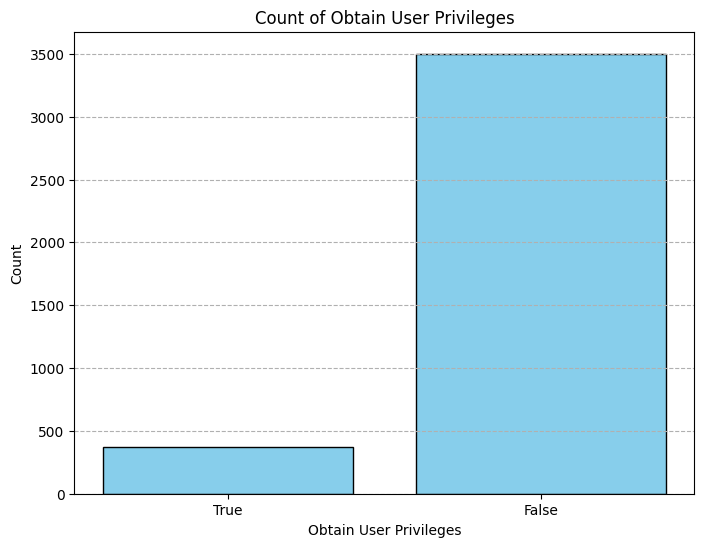

In [ ]:
# Plotting the bar chart for the count of Obtain User Privileges
plt.figure(figsize=(8, 6))
plt.bar(categories, counts_with_zeros, color=['skyblue' if count > 0 else 'white' for count in counts_with_zeros], edgecolor='black')

plt.title('Count of Obtain User Privileges')  # Title of the plot
plt.xlabel('Obtain User Privileges')  # X-axis label
plt.ylabel('Count')  # Y-axis label
plt.grid(axis='y', linestyle='--')  # Adding a grid to the Y-axis

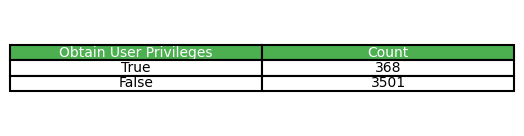

In [ ]:
table_data = [[cat, count] for cat, count in zip(categories, counts_with_zeros)]
col_labels = ['Obtain User Privileges', 'Count']

fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('off')
table = ax.table(cellText=table_data, colLabels=col_labels, cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

for i in range(len(col_labels)):
    table[0, i].set_facecolor('#4CAF50')
    table[0, i].set_text_props(color='white')

for key, cell in table.get_celld().items():
    cell.set_edgecolor('black')
    cell.set_linewidth(1.5)
    cell.set_text_props(ha='center', va='center')
    cell.PAD = 1

plt.subplots_adjust(left=0.2, bottom=0.3)
plt.show()

This cell visualizes the "Confidentiality Impact" data by creating a bar plot with a table that displays the count of each impact category ("NONE", "PARTIAL", "COMPLETE"), ensuring clear and effective presentation.

In [ ]:
categories = ['NONE', 'PARTIAL', 'COMPLETE']
confidentiality_counts = df['Confidentiality_Impact'].value_counts()
counts_with_zeros = [confidentiality_counts.get(cat, 0) for cat in categories]

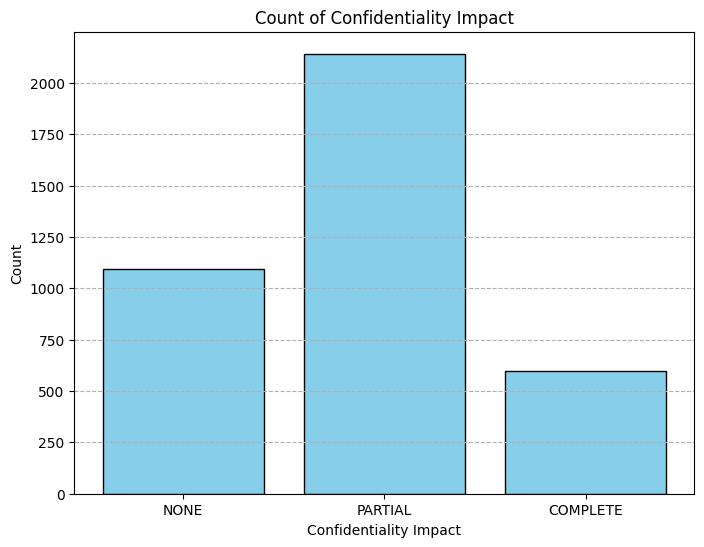

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(categories, counts_with_zeros, color=['skyblue' if count > 0 else 'white' for count in counts_with_zeros], edgecolor='black')

plt.title('Count of Confidentiality Impact')
plt.xlabel('Confidentiality Impact')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--')

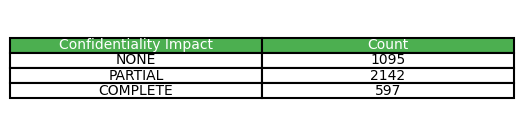

In [ ]:
# Preparing the data for the table
table_data = [[cat, count] for cat, count in zip(categories, counts_with_zeros)]
col_labels = ['Confidentiality Impact', 'Count']

# Creating a table and formatting its appearance
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('off')  # Hiding the axis
table = ax.table(cellText=table_data, colLabels=col_labels, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Formatting header row with a specific color
for i in range(len(col_labels)):
    table[0, i].set_facecolor('#4CAF50')
    table[0, i].set_text_props(color='white')

# Styling the table cells (edges, text alignment, padding)
for key, cell in table.get_celld().items():
    cell.set_edgecolor('black')
    cell.set_linewidth(1.5)
    cell.set_text_props(ha='center', va='center')
    cell.PAD = 1

plt.subplots_adjust(left=0.2, bottom=0.3)  # Adjusting layout
plt.show()  # Displaying the table

This cell visualizes the "Integrity Impact" data with a bar plot and a table displaying the count of each impact category ("NONE", "PARTIAL", "COMPLETE"). It ensures a clear presentation of the results.

In [ ]:
categories = ['NONE', 'PARTIAL', 'COMPLETE']
integrity_counts = df['Integrity_Impact'].value_counts()
counts_with_zeros = [integrity_counts.get(cat, 0) for cat in categories]

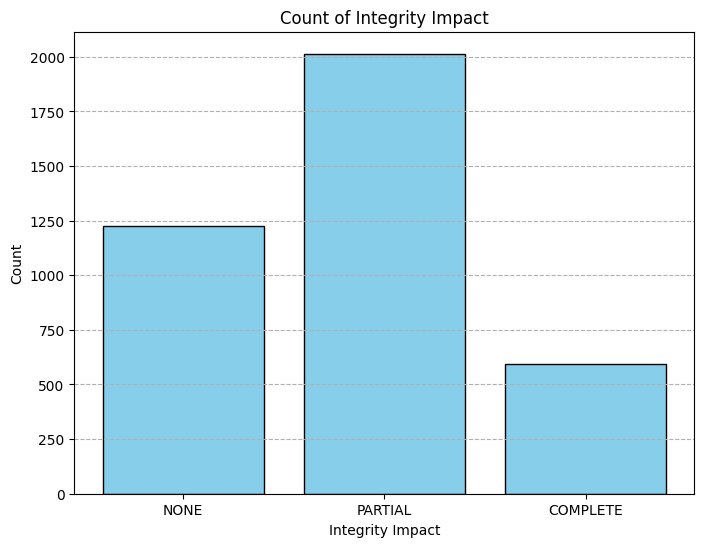

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(categories, counts_with_zeros, color=['skyblue' if count > 0 else 'white' for count in counts_with_zeros], edgecolor='black')

plt.title('Count of Integrity Impact')
plt.xlabel('Integrity Impact')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--')

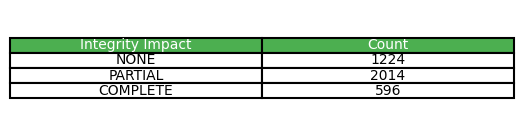

In [ ]:
table_data = [[cat, count] for cat, count in zip(categories, counts_with_zeros)]
col_labels = ['Integrity Impact', 'Count']

fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('off')
table = ax.table(cellText=table_data, colLabels=col_labels, cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

for i in range(len(col_labels)):
    table[0, i].set_facecolor('#4CAF50')
    table[0, i].set_text_props(color='white')

for key, cell in table.get_celld().items():
    cell.set_edgecolor('black')
    cell.set_linewidth(1.5)
    cell.set_text_props(ha='center', va='center')
    cell.PAD = 1

plt.subplots_adjust(left=0.2, bottom=0.3)
plt.show()

This cell visualizes the "Availability Impact" data by generating a bar plot and a corresponding table, displaying the count of each impact category ("NONE", "PARTIAL", "COMPLETE"). It ensures a clear and informative presentation.

In [ ]:
categories = ['NONE', 'PARTIAL', 'COMPLETE']
availability_counts = df['Availability_Impact'].value_counts()
counts_with_zeros = [availability_counts.get(cat, 0) for cat in categories]

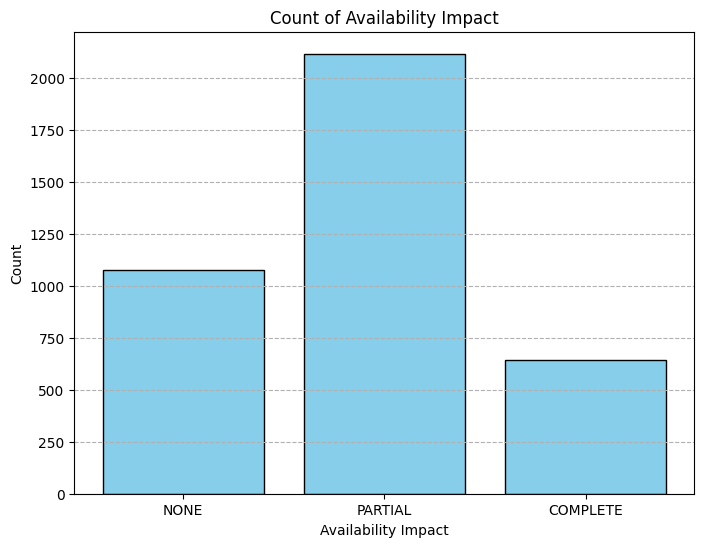

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(categories, counts_with_zeros, color=['skyblue' if count > 0 else 'white' for count in counts_with_zeros], edgecolor='black')

plt.title('Count of Availability Impact')
plt.xlabel('Availability Impact')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--')

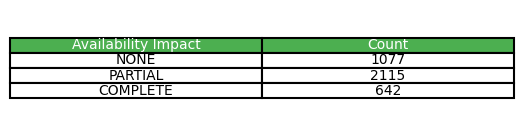

In [ ]:
table_data = [[cat, count] for cat, count in zip(categories, counts_with_zeros)]
col_labels = ['Availability Impact', 'Count']

fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('off')
table = ax.table(cellText=table_data, colLabels=col_labels, cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

for i in range(len(col_labels)):
    table[0, i].set_facecolor('#4CAF50')
    table[0, i].set_text_props(color='white')

for key, cell in table.get_celld().items():
    cell.set_edgecolor('black')
    cell.set_linewidth(1.5)
    cell.set_text_props(ha='center', va='center')
    cell.PAD = 1

plt.subplots_adjust(left=0.2, bottom=0.3)
plt.show()

In [ ]:
# Defining the categories for Access Vector
categories = ['PHYSICAL', 'NETWORK', 'ADJACENT', 'LOCAL']

# Counting occurrences of each Access Vector in the dataframe
access_vector_counts = df['Access_Vector'].value_counts()

# Getting the count for each category, including zeros for missing categories
counts_with_zeros = [access_vector_counts.get(cat, 0) for cat in categories]

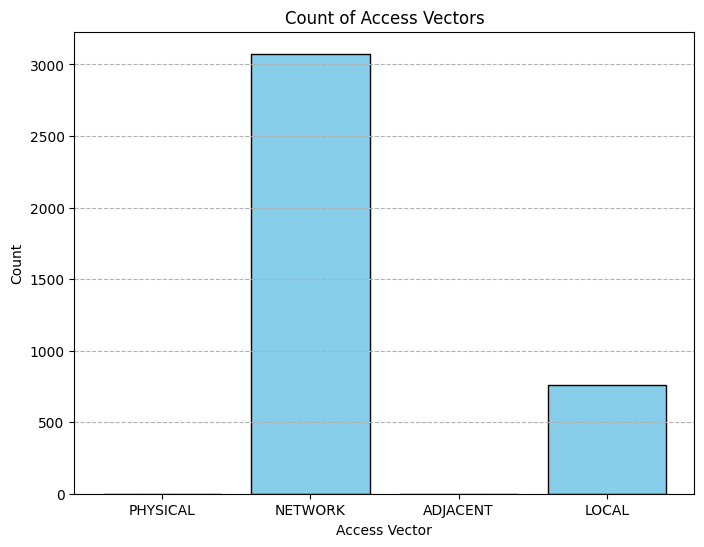

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(categories, counts_with_zeros, color=['skyblue' if count > 0 else 'white' for count in counts_with_zeros], edgecolor='black')

plt.title('Count of Access Vectors')
plt.xlabel('Access Vector')
plt.ylabel('Count')

plt.grid(axis='y', linestyle='--')

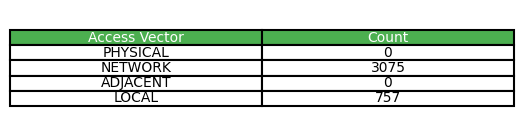

In [ ]:
table_data = [[cat, count] for cat, count in zip(categories, counts_with_zeros)]
col_labels = ['Access Vector', 'Count']

fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('off')
table = ax.table(cellText=table_data, colLabels=col_labels, cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

for i in range(len(col_labels)):
    cell = table[0, i]
    cell.set_facecolor('#4CAF50')
    cell.set_text_props(color='white')

for key, cell in table.get_celld().items():
    cell.set_edgecolor('black')
    cell.set_linewidth(1.5)
    cell.set_text_props(ha='center', va='center')
    cell.PAD = 1

plt.subplots_adjust(left=0.2, bottom=0.3)

plt.show()

In [ ]:
categories = ['Analyzed', 'Modified']
vulnerability_status_counts = df['Vulnerability_Status'].value_counts()
counts_with_zeros = [vulnerability_status_counts.get(cat, 0) for cat in categories]

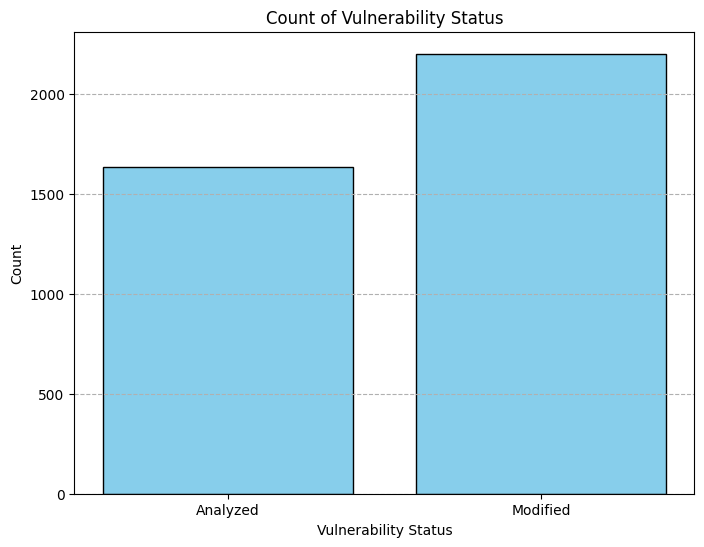

In [ ]:
# Creating a bar chart for the count of Vulnerability Status
plt.figure(figsize=(8, 6))
plt.bar(categories, counts_with_zeros, color=['skyblue' if count > 0 else 'white' for count in counts_with_zeros], edgecolor='black')

plt.title('Count of Vulnerability Status')  # Title of the plot
plt.xlabel('Vulnerability Status')  # X-axis label
plt.ylabel('Count')  # Y-axis label

plt.grid(axis='y', linestyle='--')  # Adding a grid to the Y-axis

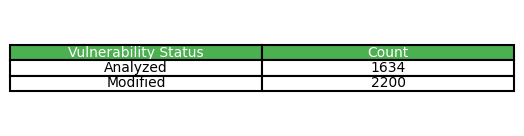

In [ ]:
table_data = [[cat, count] for cat, count in zip(categories, counts_with_zeros)]
col_labels = ['Vulnerability Status', 'Count']

fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('off')
table = ax.table(cellText=table_data, colLabels=col_labels, cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

for i in range(len(col_labels)):
    cell = table[0, i]
    cell.set_facecolor('#4CAF50')
    cell.set_text_props(color='white')

for key, cell in table.get_celld().items():
    cell.set_edgecolor('black')
    cell.set_linewidth(1.5)
    cell.set_text_props(ha='center', va='center')
    cell.PAD = 1

plt.subplots_adjust(left=0.2, bottom=0.3)
plt.show()

Plot a pie chart showing the percentage distribution of different severity levels in the dataset.

In [ ]:
#print(df['Impact_Score'].apply(lambda x: isinstance(x, (int, float))).value_counts())
df['Impact_Score'] = pd.to_numeric(df['Impact_Score'], errors='coerce')
bins_5 = [0, 3.9, 6.9, 10]
labels_5 = ['Low', 'Medium', 'High']

df['Severity_Group_51'] = pd.cut(df['Impact_Score'], bins=bins_5, labels=labels_5, include_lowest=True)
group_counts_5 = df['Severity_Group_51'].value_counts()
group_counts_5 = group_counts_5[group_counts_5 > 0]

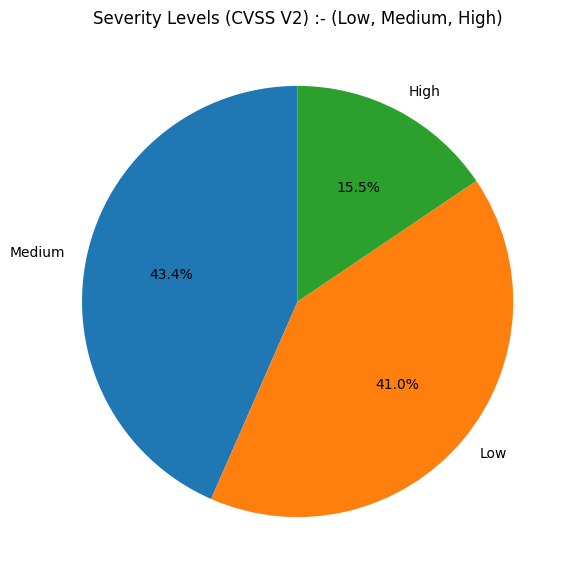

In [ ]:
plt.figure(figsize=(7, 7))
plt.pie(group_counts_5, labels=group_counts_5.index, autopct='%1.1f%%', startangle=90)
plt.title('Severity Levels (CVSS V2) :- (Low, Medium, High)')
plt.show()

In [ ]:
#print(df['Impact_Score'].apply(lambda x: isinstance(x, (int, float))).value_counts())
df['Impact_Score'] = pd.to_numeric(df['Impact_Score'], errors='coerce')
bins_5 = [0, 0.1, 3.9, 6.9, 8.9, 10]  # Define bins
labels_5 = ['None', 'Low', 'Medium', 'High', 'Critical']  # Labels for bins
df['Severity_Group_52'] = pd.cut(df['Impact_Score'], bins=bins_5, labels=labels_5, include_lowest=True)
group_counts_5 = df['Severity_Group_52'].value_counts()
group_counts_5 = group_counts_5[group_counts_5 > 0]

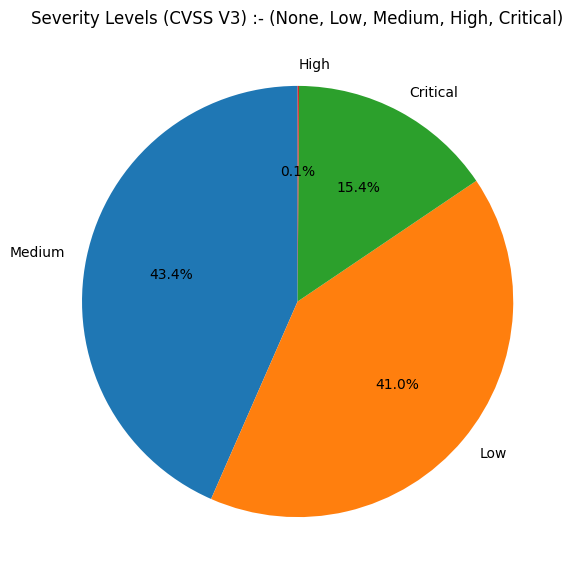

In [ ]:
plt.figure(figsize=(7, 7))
plt.pie(group_counts_5, labels=group_counts_5.index, autopct='%1.1f%%', startangle=90)
plt.title('Severity Levels (CVSS V3) :- (None, Low, Medium, High, Critical)')
plt.show()

In [ ]:
#print(df['Impact_Score'].apply(lambda x: isinstance(x, (int, float))).value_counts())
df['Impact_Score'] = pd.to_numeric(df['Impact_Score'], errors='coerce')
bins_5 = [0, 0.1, 3.9, 6.9, 8.9, 10]  # Define bins
labels_5 = ['None', 'Low', 'Medium', 'High', 'Critical']
df['Severity_Group_53'] = pd.cut(df['Impact_Score'], bins=bins_5, labels=labels_5, include_lowest=True)
group_counts_5 = df['Severity_Group_53'].value_counts()
group_counts_5 = group_counts_5[group_counts_5 > 0]

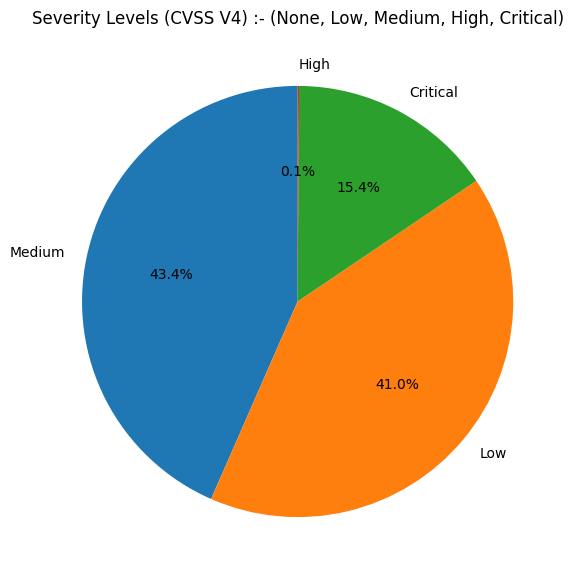

In [ ]:
plt.figure(figsize=(7, 7))
plt.pie(group_counts_5, labels=group_counts_5.index, autopct='%1.1f%%', startangle=90)
plt.title('Severity Levels (CVSS V4) :- (None, Low, Medium, High, Critical)')
plt.show()

In [ ]:
# Defining custom bins and labels for Impact Score grouping
bins_custom = list(range(0, 11, 1))
labels_custom = [f'{i} to {i+1}' for i in range(10)]

# Creating custom severity groups based on Impact Score
df['Custom_Severity_Group'] = pd.cut(df['Impact_Score'], bins=bins_custom, labels=labels_custom, include_lowest=True)

# Counting the occurrences of each severity group and filtering out zero counts
group_counts_custom = df['Custom_Severity_Group'].value_counts()
group_counts_custom = group_counts_custom[group_counts_custom > 0]

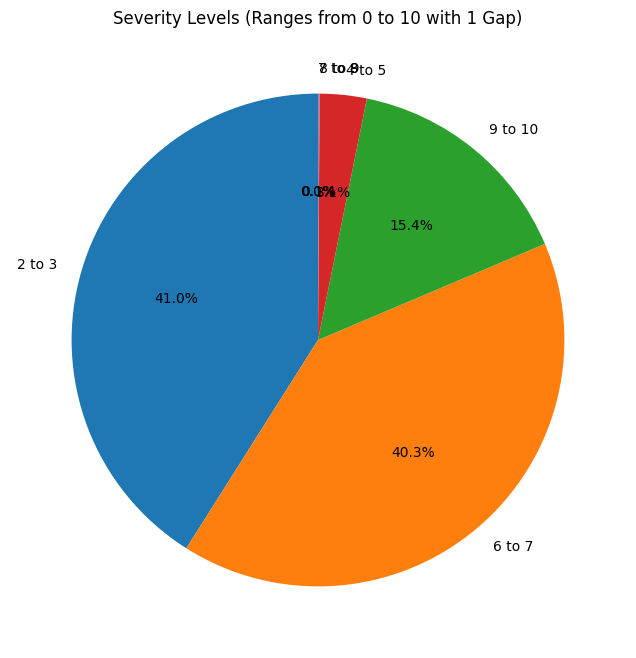

In [ ]:
colors_custom = plt.cm.tab10.colors[:len(group_counts_custom)]
plt.figure(figsize=(8, 8))
plt.pie(group_counts_custom, labels=group_counts_custom.index, colors=colors_custom, autopct='%1.1f%%', startangle=90)
plt.title('Severity Levels (Ranges from 0 to 10 with 1 Gap)')
plt.show()

Create a bar chart displaying the number of vulnerabilities reported each year, sorted by year.

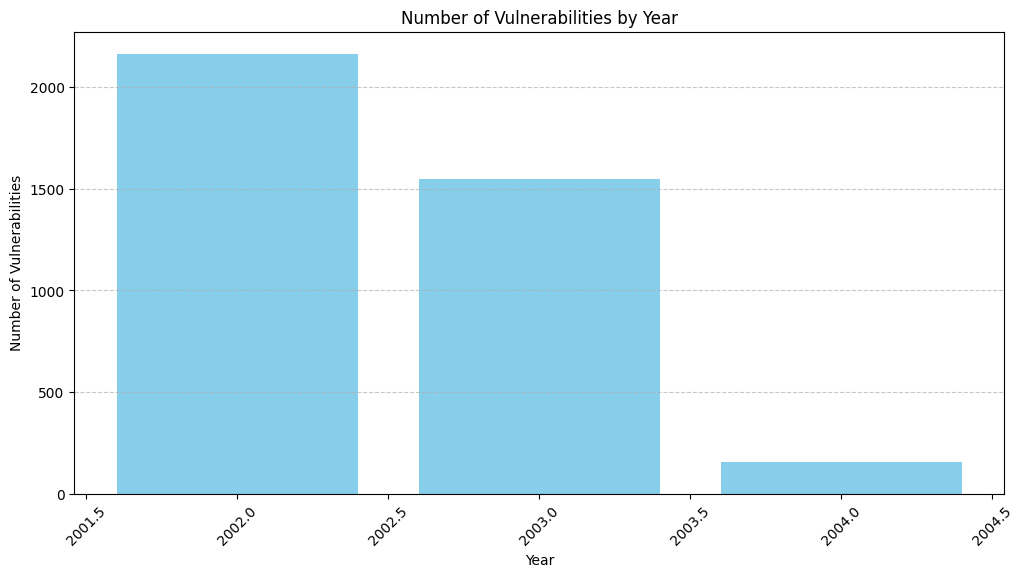

In [ ]:
plt.figure(figsize=(12, 6))
year_counts = df['Published_Year'].value_counts().sort_index()
plt.bar(year_counts.index, year_counts.values, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Vulnerabilities')
plt.title('Number of Vulnerabilities by Year')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Generate a bar chart showing the frequency distribution of different attack vectors in the dataset.

In [ ]:
def analyze_vulnerability_data(df):
    # Plotting the trends of CVEs published over time
    trends_over_time = df['Published_Year'].value_counts().sort_index()

    plt.figure(figsize=(12, 6))
    trends_over_time.plot(kind='line', marker='o')  # Line plot for trends over time
    plt.title('Trends of CVEs Published Over Time')
    plt.xlabel('Year')
    plt.ylabel('Number of CVEs')
    plt.grid()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Grouping by Attack Vector and Severity to display summary stats
    summary_stats = df.groupby('Attack_Vector')['Severity'].value_counts().unstack(fill_value=0)
    print(summary_stats)

    # Plotting summary statistics of severities by attack vectors
    summary_stats.plot(kind='bar', stacked=True, figsize=(12, 6))  # Stacked bar chart
    plt.title('Summary Statistics of Severities by Attack Vectors')
    plt.xlabel('Attack Vector')
    plt.ylabel('Number of CVEs')
    plt.legend(title='Severity')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [ ]:
def clean_dataframe(df):
    df['Impact_Score'] = pd.to_numeric(df['Impact_Score'], errors='coerce')
    df['Base_Score'] = pd.to_numeric(df['Base_Score'], errors='coerce')
    df.dropna(subset=['Impact_Score', 'Base_Score'], inplace=True)
    return df

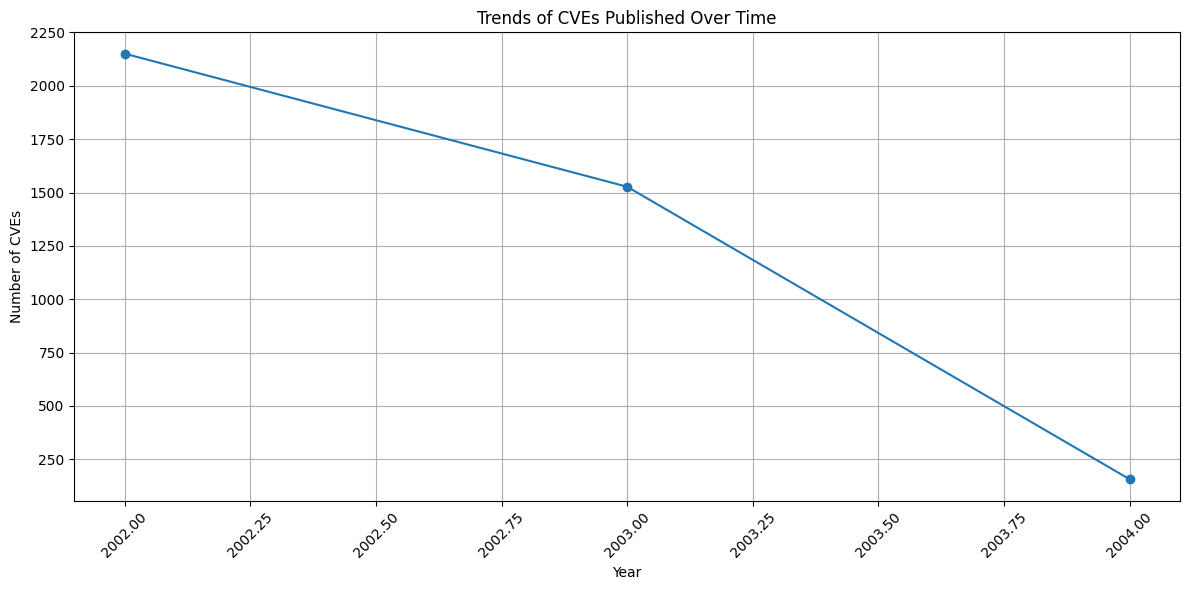

Severity                    HIGH  LOW  MEDIUM
Attack_Vector                                
AV:A/AC:L/Au:N/C:P/I:P/A:N     0    0       1
AV:A/AC:M/Au:S/C:N/I:N/A:C     0    0       1
AV:L/AC:H/Au:N/C:C/I:C/A:C     0    0      14
AV:L/AC:H/Au:N/C:N/I:N/A:C     0    0       1
AV:L/AC:H/Au:N/C:N/I:N/A:P     0    5       0
...                          ...  ...     ...
AV:N/AC:M/Au:S/C:N/I:N/A:C     0    0       2
AV:N/AC:M/Au:S/C:N/I:P/A:N     0    1       0
AV:N/AC:M/Au:S/C:P/I:N/A:N     0    1       0
AV:N/AC:M/Au:S/C:P/I:P/A:N     0    0       1
AV:N/AC:M/Au:S/C:P/I:P/A:P     0    0       1

[76 rows x 3 columns]


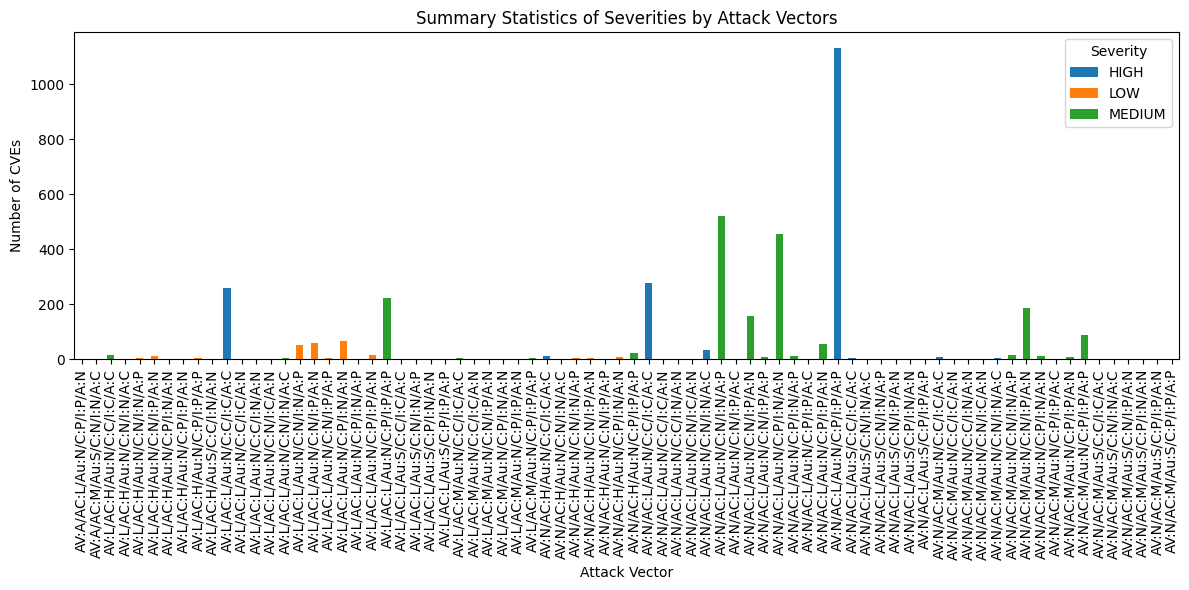

In [ ]:
df = clean_dataframe(df)
analyze_vulnerability_data(df)

Filter vulnerabilities by year range and specific operating systems/products, then plots a bar chart showing the number of vulnerabilities for these operating systems/products within the specified years.

In [ ]:
def plot_os_distribution(df):
    # Convert 'Published_Year' to integer for grouping
    df['Published_Year'] = df['Published_Year'].astype(int)

    # Normalize various OS/product names to standard labels
    def normalize_os(product):
        product = product.lower()
        if 'windows_10' in product or 'windows:10' in product:
            return 'Windows 10'
        elif 'windows_8' in product or 'windows:8' in product:
            return 'Windows 8'
        elif 'windows_7' in product or 'windows:7' in product:
            return 'Windows 7'
        elif 'windows_nt' in product or 'windows:nt' in product:
            return 'Windows NT'
        elif 'mac' in product or 'macos' in product:
            return 'MacOS'
        elif 'linux' in product:
            return 'Linux Kernel Version'
        elif 'sql' in product:
            return 'MySql'
        elif 'postgres' in product or 'post gres' in product:
            return 'Postgres'
        elif 'apache' in product:
            return 'Apache'
        elif 'apple' in product:
            return 'Apple'
        elif 'samba' in product:
            return 'Samba'
        else:
            return 'Other'

    # Flatten and normalize OS/product lists from dataframe for consistency
    os_products_flat = [item.strip() for sublist in df['Operating_System/Product'].dropna().tolist() for item in sublist.split(',')]
    normalized_products = [normalize_os(item) for item in os_products_flat]

    # Add normalized OS/product labels to dataframe and explode list values for grouping
    df['Normalized_OS'] = df['Operating_System/Product'].apply(lambda x: [normalize_os(prod.strip()) for prod in x.split(',')])
    exploded_df = df.explode('Normalized_OS')

    # Group data by year and normalized OS/product, then plot as stacked horizontal bar chart
    os_product_year_counts = exploded_df.groupby(['Published_Year', 'Normalized_OS']).size().unstack(fill_value=0)
    plt.figure(figsize=(14, 8))
    os_product_year_counts.plot(kind='barh', stacked=True, colormap='viridis', ax=plt.gca())

    # Labeling and aesthetics for plot
    plt.ylabel('Year')
    plt.xlabel('Number of Vulnerabilities')
    plt.title('Year-wise Distribution of Vulnerabilities by Operating Systems/Products')
    plt.legend(title='Operating System/Product', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

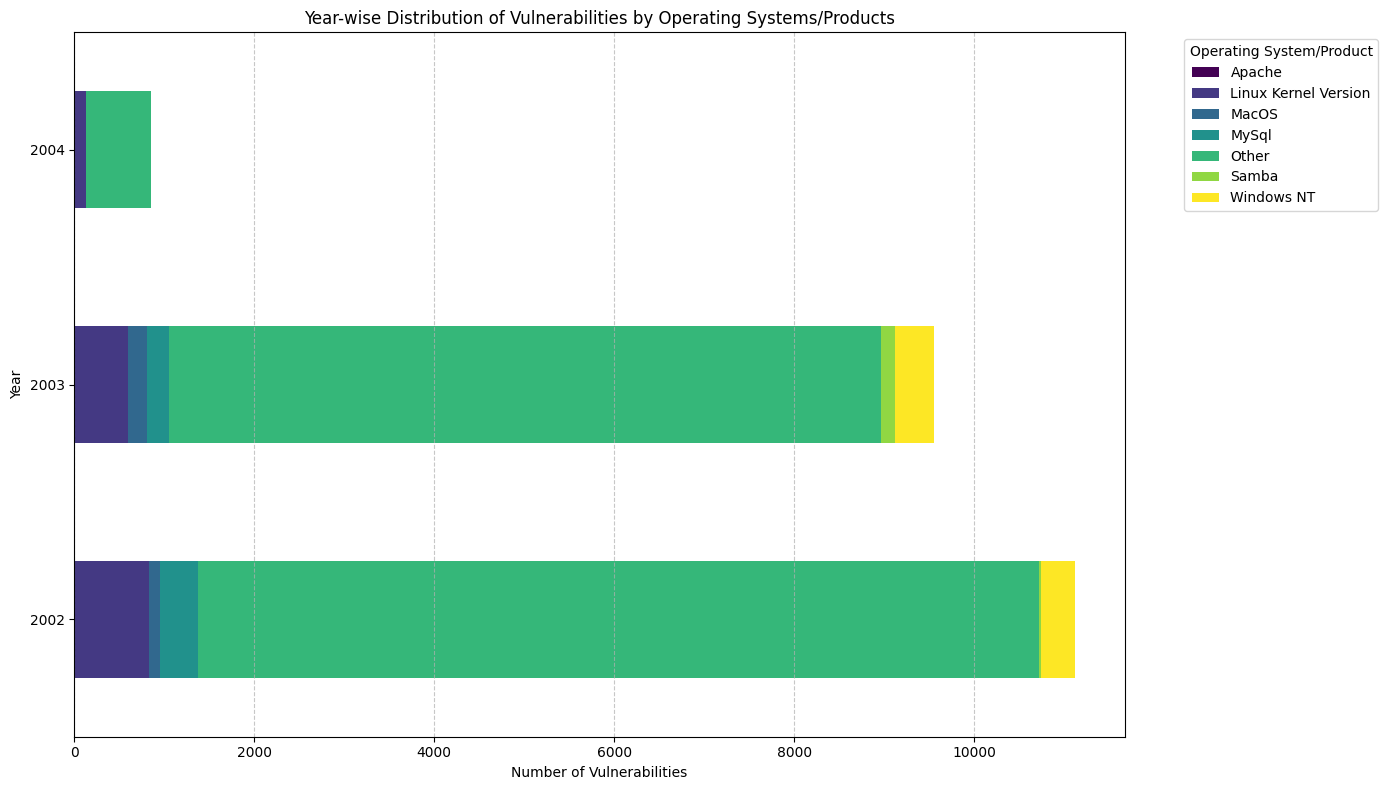

In [ ]:
plot_os_distribution(df)

Define a function that applies user-specified filters to a DataFrame of vulnerabilities based on CVE data. The function offers various options, such as filtering by CVE ID, severity, operating system, date, and more, and returns the filtered results.

In [ ]:
def filter_vulnerabilities(df):
    print("Available Filters:")
    print("1. CVE ID")
    print("2. Severity")
    print("3. Operating System/Product")
    print("4. Access Vector")
    print("5. Date Published")
    print("6. Year Published")
    print("7. Impact Score")
    print("8. Confidentiality Impact")
    print("9. Year Range (e.g., 2020-2022)")
    print("10. Date Range (e.g., 1988-11-11 to 2008-09-09)")
    print("11. Apply multiple filters (comma separated, e.g., 1,2,3)")

    # Get user input for filter choice
    filter_choice = input("Choose a filter (1-11): ")
    filtered_df = df.copy()

    if filter_choice == '11':
        selected_filters = input("Enter filter numbers (comma separated, e.g., 1,2,...,10): ").split(',')
    else:
      selected_filters = filter_choice

    # Apply filters based on user selection
    for choice in selected_filters:
        choice = choice.strip()
        if choice == '1':
            cve_id = input("Enter CVE ID (e.g., CVE-2021-12345): ")
            filtered_df = filtered_df[filtered_df['CVE_ID'].str.contains(cve_id, case=False, na=False)]
        elif choice == '2':
            severity = input("Enter severity (e.g., Low, Medium, High): ")
            filtered_df = filtered_df[filtered_df['Severity'].str.contains(severity, case=False, na=False)]
        elif choice == '3':
            os_product = input("Enter Operating System/Product (e.g., Windows, Linux): ")
            filtered_df = filtered_df[filtered_df['Operating_System/Product'].str.contains(os_product, case=False, na=False)]
        elif choice == '4':
            access_vector = input("Enter access vector (e.g., Network, Local): ")
            filtered_df = filtered_df[filtered_df['Access_Vector'].str.contains(access_vector, case=False, na=False)]
        elif choice == '5':
            date_published = input("Enter date published (YYYY-MM-DD): ")
            filtered_df = filtered_df[filtered_df['Published_Dates'].astype(str).str.contains(date_published, na=False)]
        elif choice == '6':
            year_published = input("Enter year published (YYYY): ")
            filtered_df = filtered_df[filtered_df['Published_Year'].astype(str).str.contains(year_published, na=False)]
        elif choice == '7':
            impact_score = input("Enter impact score: ")
            filtered_df = filtered_df[filtered_df['Impact_Score'] == impact_score]
        elif choice == '8':
            confidentiality_impact = input("Enter confidentiality impact (e.g., None, Low, High): ")
            filtered_df = filtered_df[filtered_df['Confidentiality_Impact'].str.contains(confidentiality_impact, case=False, na=False)]
        elif choice == '9':
            start_year = int(input("Enter start year (YYYY): "))
            end_year = int(input("Enter end year (YYYY): "))
            # Filter by year range
            filtered_df = filtered_df[
                (filtered_df['Published_Year'] >= start_year) &
                (filtered_df['Published_Year'] <= end_year)
            ]
        elif choice == '10':
            start_date = input("Enter start date (YYYY-MM-DD): ")
            end_date = input("Enter end date (YYYY-MM-DD): ")
            # Filter by date range
            filtered_df = filtered_df[
                (pd.to_datetime(filtered_df['Published_Dates'], errors='coerce') >= pd.to_datetime(start_date)) &
                (pd.to_datetime(filtered_df['Published_Dates'], errors='coerce') <= pd.to_datetime(end_date))
            ]
        else:
            print(f"Invalid choice: {choice}. This filter will be skipped.")

    # Handle empty results
    if filtered_df.empty:
        print("No records match the filtering criteria.")
    else:
        print("Total Records: ", len(filtered_df))
        print("Filtered Data:")
    return filtered_df

filtered_df = filter_vulnerabilities(df)

filtered_df

Available Filters:
1. CVE ID
2. Severity
3. Operating System/Product
4. Access Vector
5. Date Published
6. Year Published
7. Impact Score
8. Confidentiality Impact
9. Year Range (e.g., 2020-2022)
10. Date Range (e.g., 1988-11-11 to 2008-09-09)
11. Apply multiple filters (comma separated, e.g., 1,2,3)
Choose a filter (1-11): 2
Enter severity (e.g., Low, Medium, High): High
Total Records:  1753
Filtered Data:


,CVE_ID,Description,Published_Year,Published_Dates,Operating_System/Product,Attack_Vector,Access_Vector,Severity,Authentication,Impact_Score,...,Confidentiality_Impact,Obtain_User_Privileges,Vulnerability_Status,Last_Modified_Date,Processed_Description,Severity_Group_51,Severity_Group_52,Severity_Group_53,Custom_Severity_Group,Normalized_OS
0,CVE-2002-1594,"Buffer overflow in (1) grpck and (2) pwck, if ...",2002,2002-01-02,"['grpck:*', 'pwck:*']",AV:L/AC:L/Au:N/C:C/I:C/A:C,LOCAL,HIGH,NaN,10.0,...,COMPLETE,False,Modified,2017-07-11T01:29:15.710,buffer overflow grpck pwck installed setuid sy...,High,Critical,Critical,9 to 10,"[Other, Other]"
5,CVE-2003-0061,Buffer overflow in passwd for HP UX B.10.20 al...,2002,2002-01-11,['hp-ux:10.20'],AV:L/AC:L/Au:N/C:C/I:C/A:C,LOCAL,HIGH,NaN,10.0,...,COMPLETE,False,Analyzed,2008-09-05T20:33:21.787,buffer overflow passwd hp ux b allows local us...,High,Critical,Critical,9 to 10,[Other]
6,CVE-2002-0077,"Microsoft Internet Explorer 5.01, 5.5 and 6.0 ...",2002,2002-01-13,"['internet_explorer:5.0.1', 'internet_explorer...",AV:N/AC:L/Au:N/C:P/I:P/A:P,NETWORK,HIGH,NaN,6.4,...,PARTIAL,False,Modified,2021-07-23T12:55:03.667,microsoft internet explorer treat object invok...,Medium,Medium,Medium,6 to 7,"[Other, Other, Other, Other, Other, Other]"
10,CVE-2001-1457,Buffer overflow in CrazyWWWBoard 2000p4 and 20...,2002,2002-01-30,"['crazywwwboard:2000lep5', 'crazywwwboard:2000...",AV:N/AC:L/Au:N/C:P/I:P/A:P,NETWORK,HIGH,NaN,6.4,...,PARTIAL,False,Modified,2017-07-11T01:29:08.257,buffer overflow crazywwwboard p lep allows rem...,Medium,Medium,Medium,6 to 7,"[Other, Other]"
11,CVE-2001-0891,Format string vulnerability in NQS daemon (nqs...,2002,2002-01-31,"['nqsdaemon:3.3.0.16', 'unicos:*']",AV:L/AC:L/Au:N/C:C/I:C/A:C,LOCAL,HIGH,NaN,10.0,...,COMPLETE,False,Modified,2017-10-10T01:29:55.640,format string vulnerability nqs daemon nqsdaem...,High,Critical,Critical,9 to 10,"[Other, Other]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3854,CVE-2004-0068,PHP remote file inclusion vulnerability in con...,2004,2004-02-17,['phpdig:*'],AV:N/AC:L/Au:N/C:P/I:P/A:P,NETWORK,HIGH,NaN,6.4,...,PARTIAL,False,Modified,2017-10-10T01:30:16.813,php remote file inclusion vulnerability config...,Medium,Medium,Medium,6 to 7,[Other]
3855,CVE-2004-0069,Format string vulnerability in HD Soft Windows...,2004,2004-02-17,['windows_ftp_server:*'],AV:N/AC:L/Au:N/C:P/I:P/A:P,NETWORK,HIGH,NaN,6.4,...,PARTIAL,False,Modified,2016-10-18T02:40:33.350,format string vulnerability hd soft window ftp...,Medium,Medium,Medium,6 to 7,[Other]
3856,CVE-2004-0070,PHP remote file inclusion vulnerability in mod...,2004,2004-02-17,['ezcontents:*'],AV:N/AC:L/Au:N/C:P/I:P/A:P,NETWORK,HIGH,NaN,6.4,...,PARTIAL,False,Modified,2017-10-10T01:30:16.877,php remote file inclusion vulnerability module...,Medium,Medium,Medium,6 to 7,[Other]
3859,CVE-2004-0073,PHP remote file inclusion vulnerability in (1)...,2004,2004-02-17,['easydynamicpages:2.0'],AV:N/AC:L/Au:N/C:P/I:P/A:P,NETWORK,HIGH,NaN,6.4,...,PARTIAL,False,Modified,2017-07-11T01:29:53.417,php remote file inclusion vulnerability config...,Medium,Medium,Medium,6 to 7,[Other]


This function parses a natural language query to extract user-intended filters for searching a DataFrame of vulnerabilities. It uses regular expressions to identify and capture different filter criteria like CVE ID, severity, operating system, publication year, impact score, and more from the input text. The extracted filters are returned in a dictionary format.

In [ ]:
def parse_natural_language_query(query):
    filters = {}

    patterns = {
        "CVE_ID": [
            r"cve id ([\w\-]+)(?:,|$)",
            r"cve ([\w\-]+)(?:,|$)",
            r"cve\s*([\w\-]+)",
        ],
        "Severity": [
            r"severity\s+(\w+)(?:\s+and|,|\s+having|$)",
            r"level of severity\s*is\s*(\w+)",
            r"severity\s*of\s*vulnerability\s*is\s*(\w+)",
        ],
        "Operating_System/Product": [
            r"operating systems\s+(\w+)(?:\s+and|,|\s+having|$)",
            r"os\s*=\s*(\w+)",
            r"product\s*=\s*(\w+)",
        ],
        "Access_Vector": [
            r"access vector\s+(\w+)(?:\s+and|,|\s+having|$)",
            r"vector\s*=\s*(\w+)",
            r"access\s*via\s*(\w+)",
        ],
        "Published_Year": [
            r"published year\s+(\d{4})(?:,|$)",
            r"year\s*(\d{4})",
            r"published in\s*(\d{4})",
        ],
        "Impact_Score": [
            r"impact score\s+(\d+)(?:\s+and|,|\s+having|$)",
            r"score\s*=\s*(\d+)",
            r"impact\s*level\s*is\s*(\d+)",
        ],
        "Confidentiality_Impact": [
            r"confidentiality impact\s+(\w+)(?:,|$)",
            r"confidentiality\s*level\s*is\s*(\w+)",
            r"confidentiality\s*=\s*(\w+)",
        ],
        "Year_Range": [
            r"year range (?:between|from)\s*(\d{4})\s*and\s*(\d{4})",
            r"year\s*(\d{4})\s*to\s*(\d{4})",
            r"years\s*in\s*(\d{4})\s*to\s*(\d{4})",
        ],
    }

    for key, pattern_list in patterns.items():
        for pattern in pattern_list:
            match = re.search(pattern, query, re.IGNORECASE)
            if match:
                if key == "year_range":
                    filters[key] = (int(match.group(1)), int(match.group(2)))
                else:
                    filters[key] = match.group(1).strip()
                break

    return filters

This function prompts the user for a natural language query, applies `parse_natural_language_query()` to extract filters, and filters a DataFrame of vulnerabilities accordingly. It displays the number of records found after each filter and prints the filtered data or a message if no records match.

In [ ]:
def filter_vulnerabilities(df):
    # Asking the user for a natural language query to filter data
    print(
        "Enter your filter query in natural language (e.g., 'show vulnerabilities with CVE ID CVE-2021-1234')."
    )
    query = input("Query: ")

    # Parsing the user's query to extract filter criteria
    filters = parse_natural_language_query(query)
    filtered_df = df.copy()

    print(filters)

    # Applying filters to the dataframe based on extracted criteria
    if "CVE_ID" in filters:
        cve_id = filters["CVE_ID"]
        filtered_df = filtered_df[
            filtered_df["CVE_ID"].str.contains(cve_id, case=False, na=False)
        ]
        print(f"Filtered by CVE_ID '{cve_id}': {filtered_df.shape[0]} records found.")

    if "Severity" in filters:
        severity = filters["Severity"]
        filtered_df = filtered_df[
            filtered_df["Severity"].str.contains(severity, case=False, na=False)
        ]
        print(f"Filtered by Severity '{severity}': {filtered_df.shape[0]} records found.")

    if "Operating_System/Product" in filters:
        os_product = filters["Operating_System/Product"]
        filtered_df = filtered_df[
            filtered_df["Operating_System/Product"].str.contains(
                os_product, case=False, na=False
            )
        ]
        print(f"Filtered by Operating_System/Product '{os_product}': {filtered_df.shape[0]} records found.")

    if "Access_Vector" in filters:
        access_vector = filters["Access_Vector"]
        filtered_df = filtered_df[
            filtered_df["Access_Vector"].str.contains(
                access_vector, case=False, na=False
            )
        ]
        print(f"Filtered by Access_Vector '{access_vector}': {filtered_df.shape[0]} records found.")

    if "Published_Year" in filters:
        published_year = filters["Published_Year"]
        filtered_df = filtered_df[
            filtered_df["Published_Year"]
            .astype(str)
            .str.contains(published_year, na=False)
        ]
        print(f"Filtered by Published_Year '{published_year}': {filtered_df.shape[0]} records found.")

    if "Impact_Score" in filters:
        impact_score = filters["Impact_Score"]
        filtered_df = filtered_df[
            filtered_df["Impact_Score"].astype(str).str.contains(impact_score, na=False)
        ]
        print(f"Filtered by Impact_Score '{impact_score}': {filtered_df.shape[0]} records found.")

    if "Confidentiality_Impact" in filters:
        confidentiality_impact = filters["Confidentiality_Impact"]
        filtered_df = filtered_df[
            filtered_df["Confidentiality_Impact"].str.contains(
                confidentiality_impact, case=False, na=False
            )
        ]
        print(f"Filtered by Confidentiality_Impact '{confidentiality_impact}': {filtered_df.shape[0]} records found.")

    if "year_range" in filters:
        start_year, end_year = filters["year_range"]
        filtered_df = filtered_df[
            (filtered_df["Published_Year"] >= start_year)
            & (filtered_df["Published_Year"] <= end_year)
        ]
        print(f"Filtered by Year Range '{start_year} to {end_year}': {filtered_df.shape[0]} records found.")

    # Checking if there are no records after filtering
    if filtered_df.empty:
        print("No records match the filtering criteria.")
    else:
        print("Filtered Data:")
        print(filtered_df)

    return filtered_df

filter_vulnerabilities(df)

Enter your filter query in natural language (e.g., 'show vulnerabilities with CVE ID CVE-2021-1234').
Query: show vulnerabilities in year 2003 with severity low
{'Severity': 'low', 'Published_Year': '2003'}
Filtered by Severity 'low': 260 records found.
Filtered by Published_Year '2003': 100 records found.
Filtered Data:
             CVE_ID                                        Description  \
2172  CVE-2003-1071  rpc.walld (wall daemon) for Solaris 2.6 throug...   
2182  CVE-2002-1392  faxspool in mgetty before 1.1.29 uses a world-...   
2185  CVE-2002-1395  Internet Message (IM) 141-18 and earlier uses ...   
2195  CVE-2003-0012  The data collection script for Bugzilla 2.14.x...   
2221  CVE-2003-1080  Unknown vulnerability in mail for Solaris 2.6 ...   
...             ...                                                ...   
3595  CVE-2003-1447  IBM WebSphere Advanced Server Edition 4.0.4 us...   
3600  CVE-2003-1452  Untrusted search path vulnerability in Qualcom...   
3608  CVE-2

,CVE_ID,Description,Published_Year,Published_Dates,Operating_System/Product,Attack_Vector,Access_Vector,Severity,Authentication,Impact_Score,...,Confidentiality_Impact,Obtain_User_Privileges,Vulnerability_Status,Last_Modified_Date,Processed_Description,Severity_Group_51,Severity_Group_52,Severity_Group_53,Custom_Severity_Group,Normalized_OS
2172,CVE-2003-1071,rpc.walld (wall daemon) for Solaris 2.6 throug...,2003,2003-01-03,"['solaris:2.5.1', 'solaris:2.6', 'solaris:7.0'...",AV:L/AC:L/Au:N/C:N/I:P/A:N,LOCAL,LOW,NaN,2.9,...,NONE,False,Modified,2018-10-30T16:26:22.763,rpcwalld wall daemon solaris allows local user...,Low,Low,Low,2 to 3,"[Other, Other, Other, Other, Other, Other, Oth..."
2182,CVE-2002-1392,faxspool in mgetty before 1.1.29 uses a world-...,2003,2003-01-17,['mgetty:*'],AV:L/AC:L/Au:N/C:N/I:P/A:N,LOCAL,LOW,NaN,2.9,...,NONE,False,Modified,2017-10-10T01:30:12.470,faxspool mgetty us worldwritable spool directo...,Low,Low,Low,2 to 3,[Other]
2185,CVE-2002-1395,Internet Message (IM) 141-18 and earlier uses ...,2003,2003-01-17,"['internet_message:133-0', 'internet_message:1...",AV:L/AC:L/Au:N/C:N/I:P/A:N,LOCAL,LOW,NaN,2.9,...,NONE,False,Analyzed,2008-09-10T19:14:29.680,internet message im earlier us predictable fil...,Low,Low,Low,2 to 3,"[Other, Other]"
2195,CVE-2003-0012,The data collection script for Bugzilla 2.14.x...,2003,2003-01-17,"['bugzilla:2.14', 'bugzilla:2.14.1', 'bugzilla...",AV:L/AC:L/Au:N/C:N/I:P/A:N,LOCAL,LOW,NaN,2.9,...,NONE,False,Modified,2016-10-18T02:28:17.573,data collection script bugzilla x x x set worl...,Low,Low,Low,2 to 3,"[Other, Other, Other, Other, Other, Other, Oth..."
2221,CVE-2003-1080,Unknown vulnerability in mail for Solaris 2.6 ...,2003,2003-02-11,[],AV:L/AC:H/Au:N/C:P/I:N/A:N,LOCAL,LOW,NaN,2.9,...,PARTIAL,False,Modified,2018-10-30T16:26:22.763,unknown vulnerability mail solaris allows loca...,Low,Low,Low,2 to 3,[Other]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,CVE-2003-1447,IBM WebSphere Advanced Server Edition 4.0.4 us...,2003,2003-12-31,['websphere_application_server:4.0.4'],AV:L/AC:M/Au:N/C:P/I:N/A:N,LOCAL,LOW,NaN,2.9,...,PARTIAL,False,Modified,2017-07-29T01:29:12.170,ibm websphere advanced server edition us weak ...,Low,Low,Low,2 to 3,[Other]
3600,CVE-2003-1452,Untrusted search path vulnerability in Qualcom...,2003,2003-12-31,"['qpopper:4.0', 'qpopper:4.0.1', 'qpopper:4.0....",AV:L/AC:L/Au:N/C:P/I:P/A:N,LOCAL,LOW,NaN,4.9,...,PARTIAL,False,Modified,2017-07-29T01:29:12.467,untrusted search path vulnerability qualcomm q...,Medium,Medium,Medium,4 to 5,"[Other, Other, Other, Other, Other, Other, Oth..."
3608,CVE-2003-1460,Worker Filemanager 1.0 through 2.7 sets the pe...,2003,2003-12-31,"['worker_filemanager:1.0', 'worker_filemanager...",AV:L/AC:L/Au:N/C:P/I:P/A:N,LOCAL,LOW,NaN,4.9,...,PARTIAL,False,Analyzed,2008-09-05T20:36:59.650,worker filemanager set permission destination ...,Medium,Medium,Medium,4 to 5,"[Other, Other, Other, Other, Other, Other, Oth..."
3611,CVE-2003-1463,Absolute path traversal vulnerability in Alt-N...,2003,2003-12-31,"['webadmin:2.0.0', 'webadmin:2.0.1', 'webadmin...",AV:N/AC:M/Au:S/C:N/I:P/A:N,NETWORK,LOW,NaN,2.9,...,NONE,False,Modified,2017-07-29T01:29:13.060,absolute path traversal vulnerability altn tec...,Low,Low,Low,2 to 3,"[Other, Other, Other]"


In [ ]:
df1=df.copy()

This code preprocesses a DataFrame by cleaning text, converting score columns to numeric, filling NaNs with mean or 'Unknown', and parsing dates.

In [ ]:
df1['Processed_Description'] = df1['Description'].apply(preprocess_text)
df1['Impact_Score'] = pd.to_numeric(df1['Impact_Score'], errors='coerce')
df1['Base_Score'] = pd.to_numeric(df1['Base_Score'], errors='coerce')
df1['Exploitability_Score'] = pd.to_numeric(df1['Exploitability_Score'], errors='coerce')

df1.fillna({
    'Impact_Score': df1['Impact_Score'].mean(),
    'Base_Score': df1['Base_Score'].mean(),
    'Exploitability_Score': df1['Exploitability_Score'].mean(),
    'Availability_Impact': 'Unknown',
    'Integrity_Impact': 'Unknown',
    'Confidentiality_Impact': 'Unknown'
}, inplace=True)

df1['Published_Year'] = pd.to_datetime(df1['Published_Year'], errors='coerce').dt.year
df1['Last_Modified_Date'] = pd.to_datetime(df1['Last_Modified_Date'], errors='coerce')

Extracts CVSS details from the `CVSS_Vector_String` column, splits the vector into key-value pairs, and normalizes them into individual columns in the DataFrame.

In [ ]:
def extract_cvss_details(vector_string):
    # Splitting CVSS vector string and extracting key-value pairs
    parts = vector_string.split('/')
    details = {part.split(':')[0]: part.split(':')[1] for part in parts if ':' in part}
    return details

# Applying the CVSS extraction function and normalizing the result into the dataframe
cvss_details = df1['CVSS_Vector_String'].apply(extract_cvss_details)
df1 = pd.concat([df1, pd.json_normalize(cvss_details)], axis=1)

Encodes categorical columns like 'Severity', 'Authentication', 'Vulnerability_Status', 'Availability_Impact', 'Integrity_Impact', and 'Confidentiality_Impact' using LabelEncoder, then saves the preprocessed DataFrame to a CSV file.

In [ ]:
label_encoders = {}
for column in ['Severity', 'Authentication', 'Vulnerability_Status', 'Availability_Impact', 'Integrity_Impact', 'Confidentiality_Impact']:
    le = LabelEncoder()
    df1[column] = le.fit_transform(df1[column])
    label_encoders[column] = le

df1.to_csv('preprocessed_vulnerabilities.csv', index=False)

Extracts the list of column names from the DataFrame `df1` that have the data type 'object', typically representing textual features.

In [ ]:
text_features = df1.select_dtypes(include=['object']).columns.tolist()

In [ ]:
print(text_features)

['CVE_ID', 'Description', 'Published_Dates', 'Operating_System/Product', 'Attack_Vector', 'Access_Vector', 'Obtain_All_Privilege', 'User_Interaction_Required', 'CVSS_Vector_String', 'Obtain_User_Privileges', 'Processed_Description', 'Normalized_OS', 'AV', 'AC', 'Au', 'C', 'I', 'A']


Extracts the columns containing text data (object type) from the DataFrame `df1` and stores them in the list `text_features`. Initializes a set of English stopwords and creates an empty DataFrame `tfidf_combined_df` to store TF-IDF features.

In [ ]:
text_features = df1.select_dtypes(include=['object']).columns.tolist()
stop_words = set(stopwords.words('english'))

tfidf_combined_df = pd.DataFrame()

Iterates over text features in `df1`, processes valid non-empty text data for each feature using `TfidfVectorizer` to extract the top 500 features, and appends the resulting TF-IDF matrices to `tfidf_combined_df`. If a feature has no valid text or if an error occurs during vectorization, it skips processing for that feature.

In [ ]:
for feature in text_features:
    # Clean and filter out empty text entries
    valid_texts = df1[feature].fillna('').str.strip()
    valid_texts = valid_texts[valid_texts != '']

    if valid_texts.empty:
        print(f"Skipping feature '{feature}' due to lack of valid text data.")
        continue

    tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words='english')

    try:
        # Generate the TF-IDF matrix and normalize the resulting features
        tfidf_matrix = tfidf_vectorizer.fit_transform(valid_texts)
        tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
        tfidf_df = tfidf_df.add_prefix(f'TFIDF_{feature}_')
        tfidf_combined_df = pd.concat([tfidf_combined_df, tfidf_df], axis=1)

    except ValueError as e:
        # Handle errors during TF-IDF computation
        print(f"Created successfully")
        continue

Created successfully
Created successfully
Created successfully
Created successfully
Created successfully
Created successfully
Created successfully
Created successfully
Created successfully


In [ ]:
df1 = pd.concat([df1, tfidf_combined_df], axis=1)
df1.to_csv('vulnerabilities_with_tfidf.csv', index=False)
print("TF-IDF features added and saved successfully.")

TF-IDF features added and saved successfully.


In [ ]:
print(df1.columns)

Index(['CVE_ID', 'Description', 'Published_Year', 'Published_Dates',
       'Operating_System/Product', 'Attack_Vector', 'Access_Vector',
       'Severity', 'Authentication', 'Impact_Score',
       ...
       'TFIDF_Processed_Description_webinf',
       'TFIDF_Processed_Description_weblogic',
       'TFIDF_Processed_Description_webserver',
       'TFIDF_Processed_Description_window',
       'TFIDF_Processed_Description_worldreadable',
       'TFIDF_Processed_Description_worldwritable',
       'TFIDF_Processed_Description_write', 'TFIDF_Processed_Description_xml',
       'TFIDF_Processed_Description_xp', 'TFIDF_Processed_Description_zone'],
      dtype='object', length=2078)


In [ ]:
df1.head()

,CVE_ID,Description,Published_Year,Published_Dates,Operating_System/Product,Attack_Vector,Access_Vector,Severity,Authentication,Impact_Score,...,TFIDF_Processed_Description_webinf,TFIDF_Processed_Description_weblogic,TFIDF_Processed_Description_webserver,TFIDF_Processed_Description_window,TFIDF_Processed_Description_worldreadable,TFIDF_Processed_Description_worldwritable,TFIDF_Processed_Description_write,TFIDF_Processed_Description_xml,TFIDF_Processed_Description_xp,TFIDF_Processed_Description_zone
0,CVE-2002-1594,"Buffer overflow in (1) grpck and (2) pwck, if ...",1970.0,2002-01-02,"['grpck:*', 'pwck:*']",AV:L/AC:L/Au:N/C:C/I:C/A:C,LOCAL,0,0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CVE-2002-1595,Cisco SN 5420 Storage Router 1.1(5) and earlie...,1970.0,2002-01-09,"['sn_5420_storage_router_firmware:1.1\\(2\\)',...",AV:N/AC:L/Au:N/C:P/I:N/A:N,NETWORK,2,0,2.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CVE-2002-1596,Cisco SN 5420 Storage Router 1.1(5) and earlie...,1970.0,2002-01-09,"['sn_5420_storage_router_firmware:1.1\\(2\\)',...",AV:N/AC:L/Au:N/C:N/I:N/A:P,NETWORK,2,0,2.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CVE-2002-1597,Cisco SN 5420 Storage Router 1.1(5) and earlie...,1970.0,2002-01-09,"['sn_5420_storage_router_firmware:1.1\\(2\\)',...",AV:N/AC:L/Au:N/C:N/I:N/A:P,NETWORK,2,0,2.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CVE-2002-1600,Directory traversal vulnerability in Mike Spic...,1970.0,2002-01-09,"['my_classifieds:1.0', 'my_classifieds:1.1', '...",AV:N/AC:L/Au:N/C:N/I:P/A:N,NETWORK,2,0,2.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Extracts the first 500 entries from the `Processed_Description` and `Operating_System/Product` columns of `df` (after dropping rows with missing values), storing them in `cve_descriptions` and `os_values` respectively.

In [ ]:
description_os = df[['Processed_Description', 'Operating_System/Product']].dropna()
cve_descriptions = description_os['Processed_Description'].to_list()[:500]
os_values = description_os['Operating_System/Product'].to_list()[:500]

Tokenizes the `cve_descriptions` into individual lowercase characters, encodes them using `LabelEncoder` for both characters and operating system values, and prepares the data for training a Hidden Markov Model (HMM). The encoded states represent characters, while the observations represent operating system values. Additionally, the unique states and observations are preprocessed and mapped to numerical values for model input.

In [ ]:
def tokenize(description):
    # Convert description to a list of lowercase characters
    return list(description.lower())

states = [tokenize(desc) for desc in cve_descriptions]

# Flatten the list of states and find unique characters (states)
flat_states = [char for sublist in states for char in sublist]
unique_states = list(set(flat_states))

unique_states.append('<UNK>')

state_encoder = LabelEncoder()
state_encoder.fit(unique_states)
encoded_states = [state_encoder.transform(chars) for chars in states]

# Flatten the encoded states into a single array
flattened_states = np.concatenate(encoded_states)

# Prepare encoded observations for the operating system values
unique_os_values = list(set(os_values))
unique_os_values.append('<UNK_OS>')

os_encoder = LabelEncoder()
os_encoder.fit(unique_os_values)

encoded_observations = os_encoder.transform(os_values)
flattened_observations = np.repeat(encoded_observations, [len(chars) for chars in encoded_states])

n_states = len(unique_states)  # Number of unique states
n_observations = len(unique_os_values)  # Number of unique OS values

Trains a **Multinomial Hidden Markov Model (HMM)** on character-level tokens from CVE descriptions, using encoded state sequences and corresponding operating system labels. The model is configured with `n_states` components and trained with sequence lengths to capture patterns in the text data.

In [ ]:
model = hmm.MultinomialHMM(n_components=n_states, n_iter=100, tol=1e-4)

lengths = [len(chars) for chars in encoded_states]
model.fit(flattened_states.reshape(-1, 1), lengths)

https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


MultinomialHMM(n_components=29, n_iter=100,
               n_trials=array([ 4, 23,  8, ...,  7, 21, 21]),
               random_state=RandomState(MT19937) at 0x7E97CE5C5E40, tol=0.0001)

Encodes a new CVE description by cleaning and tokenizing the text, then transforming each character into a numerical representation using the pre-trained `state_encoder` of a Hidden Markov Model (HMM), replacing unknown characters with a default `<UNK>` label.

In [ ]:
def encode_new_description(description, state_encoder):
    # Tokenize description and encode each character
    chars = tokenize(description)
    encoded_chars = []
    for char in chars:
        # Encode character or assign '<UNK>' if not found
        if char in state_encoder.classes_:
            encoded_chars.append(state_encoder.transform([char])[0])
        else:
            encoded_chars.append(state_encoder.transform(['<UNK>'])[0])
    return np.array(encoded_chars).reshape(-1, 1)

# Example description and cleaning process
new_description = "Cisco SN 5420 Storage Router 1.1(5) and earlier allows attackers to read configuration files without authorization."
new_description = re.sub(r'\d+', '', new_description)  # Remove digits
new_description = re.sub(r'[^\w\s]', '', new_description)  # Remove punctuation
words = word_tokenize(new_description.lower())  # Tokenize and lower case
words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]  # Lemmatize
cleaned_text = ' '.join(words)  # Join cleaned words back into text

# Encode the cleaned description
encoded_new_states = encode_new_description(cleaned_text, state_encoder)

Decodes the encoded states of a new CVE description using the Viterbi algorithm, providing the most likely sequence of observations and the associated log-likelihood probability based on the trained Hidden Markov Model (HMM).

In [ ]:
logprob, predicted_observations = model.decode(encoded_new_states, algorithm="viterbi")

Decodes the predicted observations (operating systems) from their encoded form back to the original OS values using the `os_encoder`, handling any unknown observations by assigning them the label `<UNK_OS>`.

In [ ]:
def decode_observations(predicted_observations, os_encoder):
    decoded_os_values = []
    for obs in predicted_observations:
        if obs < len(os_encoder.classes_):
            decoded_os_values.append(os_encoder.inverse_transform([obs])[0])
        else:
            decoded_os_values.append('<UNK_OS>')
    return decoded_os_values
predicted_os_values = decode_observations(predicted_observations, os_encoder)

Prints the cleaned and processed new description along with the predicted operating system (OS) values derived from the model's prediction for the given description.

In [ ]:
print(f"New Description: {new_description}")
print(f"Predicted OS Values: {predicted_os_values[0]}")

New Description: Cisco SN  Storage Router  and earlier allows attackers to read configuration files without authorization
Predicted OS Values: ['anthill:*']


Extract BERT embeddings from text by tokenizing input, processing it through a pre-trained `bert-base-uncased` model, and returning the mean-pooled sentence embedding for further use.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')  # Load BERT tokenizer
model = BertModel.from_pretrained('bert-base-uncased')  # Load pre-trained BERT model

def get_bert_embedding(text):
    # Tokenize the input text and return tensors
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

    with torch.no_grad():  # Disable gradient computation for inference
        outputs = model(**inputs)

    # Extract the embeddings and compute the mean over the sequence
    embeddings = outputs.last_hidden_state
    sentence_embedding = torch.mean(embeddings, dim=1).squeeze().numpy()

    return sentence_embedding  # Return the sentence embedding as a NumPy array

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Prepare a dataset by encoding operating system labels and extracting BERT embeddings for CVE descriptions. It then splits the data into training and test sets, trains a logistic regression classifier on the embeddings, and predicts operating system labels for the test set.

In [ ]:
description_os = df[['Processed_Description', 'Operating_System/Product']].dropna()

cve_descriptions = description_os['Processed_Description'].to_list()[:500]
os_labels = description_os['Operating_System/Product'].to_list()[:500]

os_encoder = LabelEncoder()
os_labels_encoded = os_encoder.fit_transform(os_labels)

embeddings = np.array([get_bert_embedding(desc) for desc in cve_descriptions])

X_train, X_test, y_train, y_test = train_test_split(embeddings, os_labels_encoded, test_size=0.2, random_state=42)

classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

The `predict_os` function processes a CVE description by cleaning and tokenizing the text, extracting its BERT embedding, and then predicting the corresponding operating system label using a trained logistic regression classifier. It returns the predicted label after decoding it.

In [ ]:
def predict_os(description):
    description = re.sub(r'\d+', '', description)
    description = re.sub(r'[^\w\s]', '', description)
    words = word_tokenize(description.lower())
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    cleaned_text = ' '.join(words)

    embedding = get_bert_embedding(cleaned_text)
    embedding = embedding.reshape(1, -1)
    predicted_label = classifier.predict(embedding)
    return os_encoder.inverse_transform(predicted_label)[0]

Process description (removes digits, punctuation, and applies tokenization and lemmatization), extracts its BERT-based embedding, and predicts the corresponding operating system using a pre-trained logistic regression classifier. The predicted OS is then printed.

In [ ]:
new_description = "Buffer overflow in Windows system allows remote attackers to cause a denial of service."
predicted_os = predict_os(new_description)
print(f"Predicted OS for the new description: {predicted_os}")

Predicted OS for the new description: ['internet_information_server:4.0', 'internet_information_services:5.0']


Initialize a pre-trained BERT model and tokenizer (`bert-base-uncased`). The `get_bert_embedding` function processes a given text, tokenizes it, and feeds it into the BERT model to obtain the embeddings. It computes the mean of the token embeddings across the sequence to produce a single sentence-level embedding, which is returned as a NumPy array.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')  # Load pre-trained BERT tokenizer
model = BertModel.from_pretrained('bert-base-uncased')  # Load pre-trained BERT model

def get_bert_embedding(text):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

    with torch.no_grad():  # Disable gradients for inference
        outputs = model(**inputs)

    # Get sentence embedding by averaging token embeddings
    embeddings = outputs.last_hidden_state
    sentence_embedding = torch.mean(embeddings, dim=1).squeeze().numpy()

    return sentence_embedding  # Return the final sentence embedding

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Preparing and encoding attack vector data, generating BERT embeddings, and training a Logistic Regression model for classification.

In [ ]:
description_attack_vector = df[['Processed_Description', 'Attack_Vector']].dropna()

cve_descriptions = description_attack_vector['Processed_Description'].to_list()[:500]
attack_vector_labels = description_attack_vector['Attack_Vector'].to_list()[:500]

attack_vector_encoder = LabelEncoder()
attack_vector_labels_encoded = attack_vector_encoder.fit_transform(attack_vector_labels)

embeddings = np.array([get_bert_embedding(desc) for desc in cve_descriptions])

X_train, X_test, y_train, y_test = train_test_split(embeddings, attack_vector_labels_encoded, test_size=0.2, random_state=42)

classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

Defining a function to preprocess a description, generate its BERT embedding, and predict the attack vector label using the trained classifier.

In [ ]:
def predict_attack_vector(description):
    # Clean and preprocess the description
    description = re.sub(r'\d+', '', description)  # Remove numbers
    description = re.sub(r'[^\w\s]', '', description)  # Remove punctuation
    words = word_tokenize(description.lower())  # Tokenize and convert to lowercase
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]  # Lemmatize and remove stop words
    cleaned_text = ' '.join(words)  # Rebuild cleaned text

    # Get the BERT embedding of the cleaned description
    embedding = get_bert_embedding(cleaned_text)
    embedding = embedding.reshape(1, -1)  # Reshape for prediction

    # Predict the attack vector and return the corresponding label
    predicted_label = classifier.predict(embedding)
    return attack_vector_encoder.inverse_transform(predicted_label)[0]

Using the `predict_attack_vector` function to classify a new description and print the predicted attack vector label.

In [ ]:
new_description = "Buffer overflow in Eudora Internet Mail Server allows remote attackers to cause a denial of service."
predicted_attack_vector = predict_attack_vector(new_description)
print(f"Predicted Attack Vector: {predicted_attack_vector}")

Predicted Attack Vector: AV:N/AC:L/Au:N/C:N/I:N/A:P


Connecting to a DuckDB database, registering the DataFrame, and loading a pre-trained tokenizer and model for text-to-SQL conversion.

In [ ]:
con = duckdb.connect()

con.register('vulnerabilities', df)

tokenizer = AutoTokenizer.from_pretrained("juierror/flan-t5-text2sql-with-schema-v2")
model = AutoModelForSeq2SeqLM.from_pretrained("juierror/flan-t5-text2sql-with-schema-v2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

Defining functions to generate SQL queries from natural language questions using a text-to-SQL model, then execute those queries on the DuckDB database.

In [ ]:
def get_prompt(tables, question):
    # Construct the prompt by combining tables and question
    prompt = f"""convert question and table into SQL query. tables: {tables}. question: {question}"""
    return prompt

def prepare_input(question: str, tables: dict):
    # Format the tables in a structured way for the model
    tables = [f"""{table_name}({",".join(tables[table_name])})""" for table_name in tables]
    tables = ", ".join(tables)  # Join all tables with commas
    prompt = get_prompt(tables, question)  # Get the final prompt
    input_ids = tokenizer(prompt, max_length=512, return_tensors="pt").input_ids  # Tokenize the prompt
    return input_ids

def inference(question: str, tables: dict) -> str:
    # Prepare the input data and run the model to generate the SQL query
    input_data = prepare_input(question=question, tables=tables)
    input_data = input_data.to(model.device)  # Ensure input is on the correct device (e.g., GPU)
    outputs = model.generate(inputs=input_data, num_beams=10, top_k=10, max_length=512)  # Generate SQL query
    result = tokenizer.decode(token_ids=outputs[0], skip_special_tokens=True)  # Decode generated query
    return result

def process_query_to_sql(query: str):
    # Define the structure of the tables involved
    tables = {
        "vulnerabilities": df.columns.tolist()  # Use DataFrame column names for the 'vulnerabilities' table
    }

    sql_query = inference(query, tables)  # Convert the natural language query to SQL
    return sql_query

def execute_sql_query(sql_query):
    # Execute the generated SQL query on the connected database
    result = con.execute(sql_query).fetchall()
    return result

Generating an SQL query from a natural language question and executing it on the DuckDB database, then printing the SQL query and its results.

In [ ]:
query = "show cve_ids with published year between 2002 and 2003"
sql_query = process_query_to_sql(query)
print(f"Generated SQL Query: {sql_query}")

result = execute_sql_query(sql_query)
print("Query Result:", result)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:404: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `10` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Generated SQL Query: SELECT CVE_ID FROM vulnerabilities WHERE Published_Year BETWEEN 2002 AND 2003
Query Result: [('CVE-2002-1594',), ('CVE-2002-1595',), ('CVE-2002-1596',), ('CVE-2002-1597',), ('CVE-2002-1600',), ('CVE-2003-0061',), ('CVE-2002-0077',), ('CVE-1999-1081',), ('CVE-1999-1091',), ('CVE-2001-0887',), ('CVE-2001-1457',), ('CVE-2001-0891',), ('CVE-2002-0002',), ('CVE-2002-0005',), ('CVE-2002-0007',), ('CVE-2002-0008',), ('CVE-2002-0009',), ('CVE-2002-0010',), ('CVE-2002-0011',), ('CVE-2002-0038',), ('CVE-2002-0043',), ('CVE-2002-0044',), ('CVE-2002-0045',), ('CVE-2002-0046',), ('CVE-2002-0047',), ('CVE-2001-1371',), ('CVE-2001-1372',), ('CVE-2002-1601',), ('CVE-2001-1058',), ('CVE-2001-1079',), ('CVE-2002-0012',), ('CVE-2002-0013',), ('CVE-2002-1603',), ('CVE-2001-1465',), ('CVE-2002-1637',), ('CVE-2002-0001',), ('CVE-2002-0003',), ('CVE-2002-0004',), ('CVE-2002-0028',), ('CVE-2002-0048',), ('CVE-2001-1376',), ('CVE-2001-1377',), ('CVE-2002-0018',), ('CVE-2002-0020',), ('CVE-

In [ ]:
query =  "select top 10 cve ids with the highest impact score"
sql_query = process_query_to_sql(query)
print(f"Generated SQL Query: {sql_query}")

result = execute_sql_query(sql_query)
print("Query Result:", result)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:404: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `10` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Generated SQL Query: SELECT CVE_ID FROM vulnerabilities ORDER BY Impact_Score DESC LIMIT 10
Query Result: [('CVE-2002-1594',), ('CVE-2003-0061',), ('CVE-2001-0891',), ('CVE-2002-0005',), ('CVE-2002-0007',), ('CVE-2002-0043',), ('CVE-2002-0012',), ('CVE-2002-0013',), ('CVE-2002-0004',), ('CVE-2002-0048',)]


Loading and preprocessing data by encoding severity labels and generating TF-IDF features, then splitting the data into training and testing sets.

In [ ]:
data = pd.read_csv('processed_data.csv')

data.dropna(subset=['Processed_Description', 'Severity'], inplace=True)  # Drop rows with missing description or severity

label_encoder = LabelEncoder()
data['severity_encoded'] = label_encoder.fit_transform(data['Severity'])  # Encode severity labels

tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf.fit_transform(data['Processed_Description']).toarray()  # Convert descriptions to TF-IDF features
y = data['severity_encoded']  # Target variable (encoded severity)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Split data into training and test sets

Initializing a dictionary of machine learning models for classification, including Logistic Regression, Random Forest, and Support Vector Machine.

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(kernel='linear', probability=True)
}

Training multiple models, evaluating their accuracy, displaying classification reports, and visualizing the comparison of model accuracies using a bar chart.


Logistic Regression Accuracy: 0.7545
              precision    recall  f1-score   support

        HIGH       0.78      0.81      0.79       357
         LOW       0.55      0.23      0.32        52
      MEDIUM       0.74      0.77      0.75       357
     Unknown       1.00      1.00      1.00         8

    accuracy                           0.75       774
   macro avg       0.77      0.70      0.72       774
weighted avg       0.75      0.75      0.75       774


Random Forest Accuracy: 0.7842
              precision    recall  f1-score   support

        HIGH       0.78      0.86      0.81       357
         LOW       0.68      0.44      0.53        52
      MEDIUM       0.80      0.76      0.78       357
     Unknown       1.00      1.00      1.00         8

    accuracy                           0.78       774
   macro avg       0.81      0.76      0.78       774
weighted avg       0.78      0.78      0.78       774


Support Vector Machine Accuracy: 0.7713
              preci

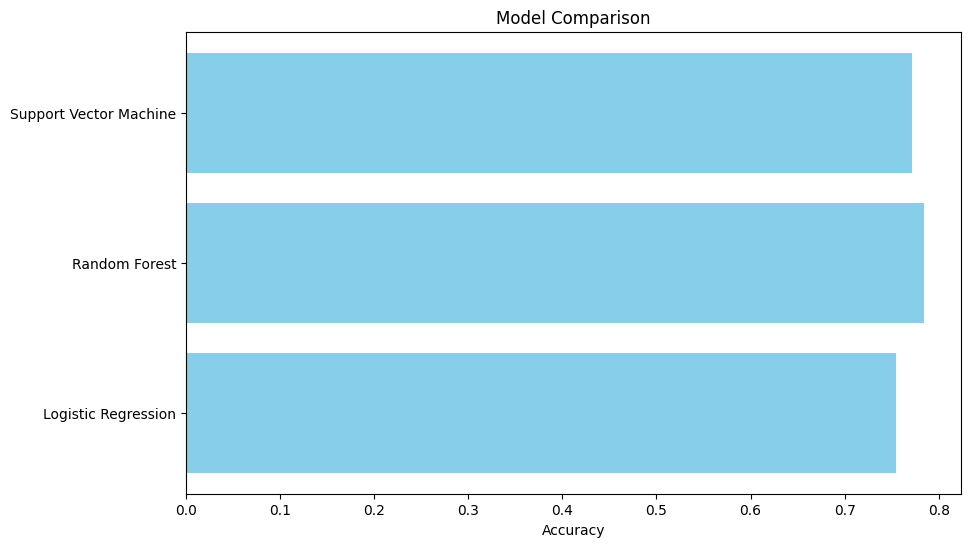

In [ ]:
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy
    print(f"\n{model_name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

plt.figure(figsize=(10, 6))
plt.barh(list(results.keys()), list(results.values()), color='skyblue')
plt.xlabel('Accuracy')
plt.title('Model Comparison')
plt.show()

Building, training, and evaluating a neural network model for classification, plotting its accuracy over epochs, and comparing its performance with other models.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.5045 - loss: 1.2184 - val_accuracy: 0.7261 - val_loss: 0.8240
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7292 - loss: 0.7440 - val_accuracy: 0.7390 - val_loss: 0.6367
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8058 - loss: 0.4898 - val_accuracy: 0.7339 - val_loss: 0.6053
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8605 - loss: 0.3464 - val_accuracy: 0.7545 - val_loss: 0.6026
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9289 - loss: 0.2415 - val_accuracy: 0.7468 - val_loss: 0.6519
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9611 - loss: 0.1402 - val_accuracy: 0.7313 - val_loss: 0.7250
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9822 - loss: 0.0781 - val_accuracy: 0.7274 - val_loss: 0.7885
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9910 - loss: 0.0518 - val_accuracy: 0.7248 - val_los

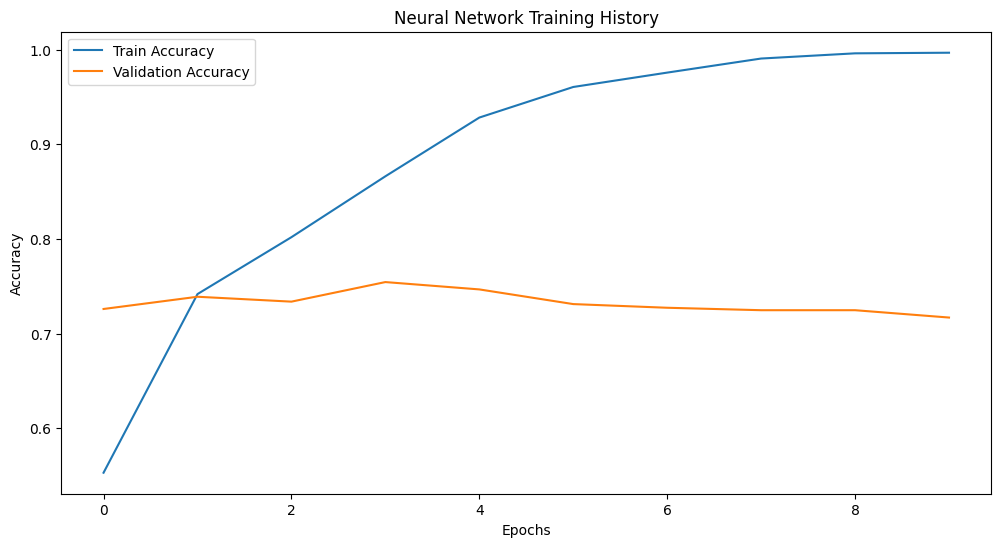

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7018 - loss: 1.0160   

Neural Network Accuracy: 0.7171

Final Model Accuracies:
Logistic Regression: 0.7545
Random Forest: 0.7842
Support Vector Machine: 0.7713
Neural Network: 0.7171


In [ ]:
nn_model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),  # First hidden layer with ReLU activation
    Dropout(0.4),  # Dropout for regularization
    Dense(256, activation='relu'),  # Second hidden layer with ReLU activation
    Dropout(0.4),  # Dropout for regularization
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer (softmax for multi-class classification)
])

nn_model.compile(optimizer=Adam(learning_rate=0.0005),
                 loss='sparse_categorical_crossentropy',  # Loss function for multi-class classification
                 metrics=['accuracy'])  # Metric for evaluating the model

history = nn_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))  # Train the model

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Neural Network Training History')
plt.show()

nn_loss, nn_accuracy = nn_model.evaluate(X_test, y_test)  # Evaluate the model on the test set
print(f"\nNeural Network Accuracy: {nn_accuracy:.4f}")

print("\nFinal Model Accuracies:")
for model_name, accuracy in results.items():  # Display accuracies of all models
    print(f"{model_name}: {accuracy:.4f}")
print(f"Neural Network: {nn_accuracy:.4f}")  # Print neural network accuracy

Evaluating and comparing the performance of multiple models, including a neural network, by generating detailed classification reports and compiling a DataFrame of key metrics (accuracy, precision, recall, F1-score) for each model, followed by visualizing the results in a bar chart.


Logistic Regression Classification Report:
              precision    recall  f1-score   support

        HIGH       0.78      0.81      0.79       357
         LOW       0.55      0.23      0.32        52
      MEDIUM       0.74      0.77      0.75       357
     Unknown       1.00      1.00      1.00         8

    accuracy                           0.75       774
   macro avg       0.77      0.70      0.72       774
weighted avg       0.75      0.75      0.75       774


Random Forest Classification Report:
              precision    recall  f1-score   support

        HIGH       0.78      0.86      0.81       357
         LOW       0.68      0.44      0.53        52
      MEDIUM       0.80      0.76      0.78       357
     Unknown       1.00      1.00      1.00         8

    accuracy                           0.78       774
   macro avg       0.81      0.76      0.78       774
weighted avg       0.78      0.78      0.78       774


Support Vector Machine Classification Report:
 

<Figure size 1200x800 with 0 Axes>

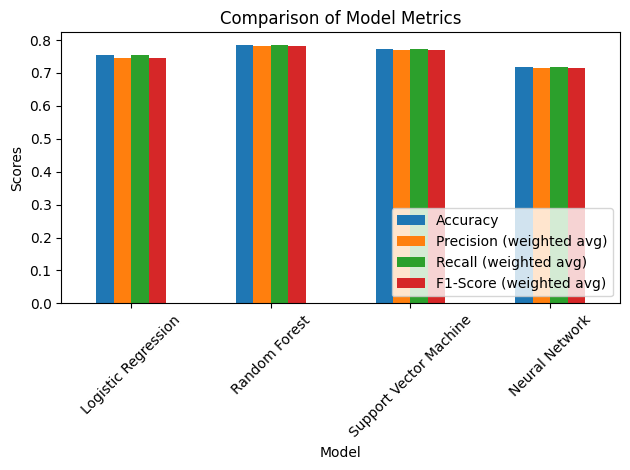

In [ ]:
detailed_results = {}

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
    detailed_results[model_name] = report
    detailed_results[model_name]['Accuracy'] = {'accuracy': accuracy}

    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

y_pred_nn = nn_model.predict(X_test)
y_pred_nn_classes = y_pred_nn.argmax(axis=1)
nn_accuracy = accuracy_score(y_test, y_pred_nn_classes)
nn_report = classification_report(y_test, y_pred_nn_classes, target_names=label_encoder.classes_, output_dict=True)
detailed_results["Neural Network"] = nn_report
detailed_results["Neural Network"]['Accuracy'] = {'accuracy': nn_accuracy}

print("\nNeural Network Classification Report:")
print(classification_report(y_test, y_pred_nn_classes, target_names=label_encoder.classes_))

results_df = pd.DataFrame.from_dict({
    model_name: {
        'Accuracy': details['Accuracy']['accuracy'],
        'Precision (weighted avg)': details['weighted avg']['precision'],
        'Recall (weighted avg)': details['weighted avg']['recall'],
        'F1-Score (weighted avg)': details['weighted avg']['f1-score']
    }
    for model_name, details in detailed_results.items()
}, orient='index')

print("\nComparison of Model Metrics:")
print(results_df)

plt.figure(figsize=(12, 8))
results_df[['Accuracy', 'Precision (weighted avg)', 'Recall (weighted avg)', 'F1-Score (weighted avg)']].plot(kind='bar')
plt.title('Comparison of Model Metrics')
plt.xlabel('Model')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

Preprocessing a custom description, transforming it using TF-IDF, and predicting the severity label using multiple models (Logistic Regression, Random Forest, SVM, and Neural Network).

In [ ]:
custom_description = "A vulnerability in the authentication module allows minor data leak."
custom_description = re.sub(r'\d+', '', custom_description)
description = re.sub(r'[^\w\s]', '', custom_description)
words = word_tokenize(custom_description.lower())
words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
cleaned_text = ' '.join(words)
custom_description_tfidf = tfidf.transform([cleaned_text]).toarray()

print("Predictions for custom description:\n")
for model_name, model in models.items():
    predicted_label = model.predict(custom_description_tfidf)[0]
    severity = label_encoder.inverse_transform([predicted_label])[0]
    print(f"{model_name} Prediction: {severity}")

nn_pred = nn_model.predict(custom_description_tfidf)
nn_predicted_label = np.argmax(nn_pred, axis=1)[0]
nn_severity = label_encoder.inverse_transform([nn_predicted_label])[0]
print(f"Neural Network Prediction: {nn_severity}")

Predictions for custom description:

Logistic Regression Prediction: MEDIUM
Random Forest Prediction: MEDIUM
Support Vector Machine Prediction: MEDIUM
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Neural Network Prediction: MEDIUM


Loading spaCy for NLP tasks, a BERT-based Named Entity Recognition (NER) pipeline, and reading and preprocessing the data, focusing on non-null entries in the 'Processed_Description' column.

In [ ]:
nlp_spacy = spacy.load("en_core_web_sm")

ner_pipeline = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english", grouped_entities=True)

data = pd.read_csv('processed_data.csv')
data.dropna(subset=['Processed_Description'], inplace=True)

sample_description = data['Processed_Description'].iloc[1]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10

Defining functions to extract entities related to organizations and products from text using spaCy and a transformer-based NER model.

In [ ]:
def extract_entities_spacy(text):
    doc = nlp_spacy(text)
    entities = []
    for ent in doc.ents:
        if ent.label_ in ["ORG", "PRODUCT"]:
            entities.append((ent.text, ent.label_))
    return entities

def extract_entities_transformer(text):
    entities = ner_pipeline(text)
    os_product_entities = [ent['word'] for ent in entities if ent['entity_group'] in ['ORG', 'MISC']]
    return os_product_entities

Printing a sample description, then extracting and displaying entities related to organizations and products using both spaCy and a transformer-based NER model.

In [ ]:
print("Sample Description:", sample_description)

print("\nEntities from spaCy:")
entities_spacy = extract_entities_spacy(sample_description)  # Extract entities using spaCy
for entity in entities_spacy:
    print(f"Entity: {entity[0]}, Label: {entity[1]}")  # Print each entity and its label

print("\nEntities from Transformer-based model:")
entities_transformer = extract_entities_transformer(sample_description)  # Extract entities using transformer model
print("Extracted Entities:", entities_transformer)  # Print the extracted entities

Sample Description: cisco sn storage router earlier allows attacker read configuration file without authorization

Entities from spaCy:
Entity: cisco sn storage router earlier, Label: ORG

Entities from Transformer-based model:
Extracted Entities: ['cisco']


Extracting entities related to organizations and products from the first 10 descriptions in the dataset using both spaCy and the transformer-based NER model, and displaying the results in a table format.

In [ ]:
data['Entities_spacy'] = data['Processed_Description'].iloc[0:10].apply(extract_entities_spacy)
data['Entities_transformer'] = data['Processed_Description'].iloc[0:10].apply(extract_entities_transformer)

print("\nExtracted entities for all descriptions using spaCy and Transformer-based models:")
data[['Description', 'Entities_spacy', 'Entities_transformer']].iloc[0:10]


Extracted entities for all descriptions using spaCy and Transformer-based models:


,Description,Entities_spacy,Entities_transformer
0,"Buffer overflow in (1) grpck and (2) pwck, if ...",[],[]
1,Cisco SN 5420 Storage Router 1.1(5) and earlie...,"[(cisco sn storage router earlier, ORG)]",[cisco]
2,Cisco SN 5420 Storage Router 1.1(5) and earlie...,"[(cisco sn storage router earlier, ORG), (remo...",[cisco]
3,Cisco SN 5420 Storage Router 1.1(5) and earlie...,"[(cisco sn storage router earlier, ORG), (remo...",[cisco]
4,Directory traversal vulnerability in Mike Spic...,[],[]
5,Buffer overflow in passwd for HP UX B.10.20 al...,[],[]
6,"Microsoft Internet Explorer 5.01, 5.5 and 6.0 ...","[(microsoft, ORG), (remote attacker invoke, ORG)]",[]
7,Vulnerability in files.pl script in Novell Web...,[],[]
8,UNIX news readers tin and rtin create the /tmp...,[],[unix]
9,xSANE 0.81 and earlier allows local users to m...,"[(xsane earlier, ORG)]",[x]


Labeling tokens in descriptions with predefined labels for operating systems (OS), attack vectors (AV), and severity (SV), then displaying the labeled tokens in a DataFrame.

In [ ]:
df = pd.read_csv('processed_data.csv')
descriptions = df['Processed_Description'].tolist()

def label_description(description):
    tokens = nltk.word_tokenize(description)  # Tokenize the description
    labels = []

    for token in tokens:
      if re.match(r'(Windows|Linux|Ubuntu|MacOS|Mac|Unix|Apple|Solaris|AIX|HP-UX|Red\s*Hat|Debian|FreeBSD|OpenBSD|NetBSD|IRIX|SCO|SunOS|Tru64|BeOS|QNX|DOS|OS/2)', token, re.IGNORECASE):
          labels.append('B-OS')  # Label OS-related tokens
      elif re.match(r'(Network|Local|Physical|Adjacent)', token, re.IGNORECASE):
          labels.append('B-AV')  # Label attack vector-related tokens
      elif re.match(r'(Low|Medium|High|Critical)', token, re.IGNORECASE):
          labels.append('B-SV')  # Label severity-related tokens
      else:
          labels.append('O')  # Label other tokens as 'O'

    return list(zip(tokens, labels))  # Return token-label pairs

labeled_data = [label_description(desc) for desc in descriptions]  # Process each description
labeled_df = pd.DataFrame([(t, l) for desc in labeled_data for t, l in desc], columns=['Token', 'Label'])  # Flatten and create DataFrame
print(labeled_df.head())  # Display first few rows of labeled data

       Token Label
0     buffer     O
1   overflow     O
2      grpck     O
3       pwck     O
4  installed     O


Converting the labeled data into sequences of tokens and corresponding BIO (Begin, Inside, Outside) labels for each description, to prepare for further model training or evaluation.

In [ ]:
def prepare_sequences(labeled_data):
    sequences = []
    labels = []

    for description in labeled_data:
        tokens, bio_labels = zip(*description)
        sequences.append(list(tokens))
        labels.append(list(bio_labels))

    return sequences, labels

sequences, bio_labels = prepare_sequences(labeled_data)

Training a Conditional Random Field (CRF) model on tokenized sequences with BIO labels, evaluating its performance on a test set, and displaying the classification report for the 'B-OS', 'B-AV', 'B-SV', and 'O' labels.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sequences, bio_labels, test_size=0.2, random_state=42)

def crf_train(X_train, y_train):
    crf = sklearn_crfsuite.CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100)
    crf.fit(X_train, y_train)
    return crf

crf_model = crf_train(X_train, y_train)
y_pred = crf_model.predict(X_test)
print(flat_classification_report(y_test, y_pred, labels=['B-OS', 'B-AV', 'B-SV', 'O']))

              precision    recall  f1-score   support

        B-OS       0.00      0.00      0.00       131
        B-AV       0.78      0.86      0.82       177
        B-SV       0.00      0.00      0.00        15
           O       0.99      1.00      0.99     16129

    accuracy                           0.99     16452
   macro avg       0.44      0.46      0.45     16452
weighted avg       0.98      0.99      0.98     16452



In [ ]:
#API KEY :- a73e9dd12d93e143da89780fdda3816df79ede06

This code tokenizes and aligns BIO labels with a BERT model for token classification, using a custom label mapping and dataset preparation. It trains a BERT model for token classification to predict labels like 'B-OS', 'I-OS', 'B-ATTACK', etc., and sets up a `Trainer` for fine-tuning with specified training arguments.

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples['text'], truncation=True, is_split_into_words=True)
    labels = []

    for i, label in enumerate(examples['label']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Mask padding tokens
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])  # Assign label for new word
            else:
                label_ids.append(label[word_idx] if label[word_idx].startswith("B") else label[word_idx].replace("B", "I"))  # IOB tagging

            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels  # Add labels to tokenized inputs
    return tokenized_inputs

unique_labels = ['B-OS', 'I-OS', 'B-ATTACK', 'I-ATTACK', 'O']  # Define unique labels
label_map = {label: i for i, label in enumerate(unique_labels)}  # Map labels to indices

sequences = ["Example sentence for labeling".split()]
bio_labels = [["O", "O", "B-OS", "I-OS", "O"]]  # Example labels in BIO format

data = [{"text": seq, "label": [label_map[l] for l in labels]} for seq, labels in zip(sequences, bio_labels)]  # Prepare dataset

dataset = Dataset.from_list(data)  # Convert data to Dataset format
tokenized_data = dataset.map(tokenize_and_align_labels, batched=True)  # Tokenize and align labels

model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=len(label_map))  # Load pre-trained model

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

print(f"Number of samples in data: {len(data)}")  # Print number of samples
if len(data) > 1:
    train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)  # Split data into training and validation
else:
    train_data = data
    val_data = data

train_dataset = Dataset.from_list(train_data)
val_dataset = Dataset.from_list(val_data)

tokenized_train = train_dataset.map(tokenize_and_align_labels, batched=True)  # Tokenize training data
tokenized_val = val_dataset.map(tokenize_and_align_labels, batched=True)  # Tokenize validation data

# Initialize and train model using Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
)

trainer.train()  # Train the model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of samples in data: 1


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,No log,1.264678
2,No log,1.100460
3,No log,1.028890


TrainOutput(global_step=3, training_loss=1.3914845784505208, metrics={'train_runtime': 56.5227, 'train_samples_per_second': 0.053, 'train_steps_per_second': 0.053, 'total_flos': 9186463260.0, 'train_loss': 1.3914845784505208, 'epoch': 3.0})

This code implements custom evaluation metrics for your BERT token classification model. It computes accuracy, precision, recall, and F1-score by using the `evaluate` library. The `compute_metrics` function compares the predictions against the true labels, ignoring padding tokens (labeled as `-100`), and then calculates the specified metrics. After training, the `trainer.evaluate()` function evaluates the model on the validation set and prints the evaluation results.

The evaluation results include:
- `accuracy`: The overall proportion of correct predictions.
- `precision`: Weighted precision, considering all labels.
- `recall`: Weighted recall, considering all labels.
- `f1`: Weighted F1-score, considering all labels.

In [ ]:
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(axis=-1)

    true_predictions = [
        pred for pred, label in zip(predictions.flatten(), labels.flatten()) if label != -100
    ]
    true_labels = [
        label for pred, label in zip(predictions.flatten(), labels.flatten()) if label != -100
    ]

    accuracy = accuracy_metric.compute(predictions=true_predictions, references=true_labels)["accuracy"]
    precision = precision_metric.compute(predictions=true_predictions, references=true_labels, average="weighted")["precision"]
    recall = recall_metric.compute(predictions=true_predictions, references=true_labels, average="weighted")["recall"]
    f1 = f1_metric.compute(predictions=true_predictions, references=true_labels, average="weighted")["f1"]

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
)

trainer.train()

eval_results = trainer.evaluate()

print(eval_results)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.844268,1.000000,1.000000,1.000000,1.000000
2,No log,0.709203,1.000000,1.000000,1.000000,1.000000
3,No log,0.637252,1.000000,1.000000,1.000000,1.000000


{'eval_loss': 0.6372524499893188, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.1491, 'eval_samples_per_second': 6.708, 'eval_steps_per_second': 6.708, 'epoch': 3.0}



This code creates a Data Flow Diagram (DFD) using Graphviz, defining nodes and edges to illustrate current and future processes, data stores, and their interactions, and saves the diagram as a PNG file named nist_database_dfd.png.

In [ ]:
# Create a new Digraph for DFD
dot = Digraph()

# Add nodes for External Data Sources
dot.node('NIST_API', 'NIST API', shape='box')
dot.node('NIST_Website', 'NIST Website (HTML)', shape='box')

# Add nodes for Current Processes
dot.node('Data_Retrieval', 'Data Retrieval (API)', shape='ellipse')
dot.node('Data_Parsing', 'Data Parsing', shape='ellipse')
dot.node('Data_Preprocessing', 'Data Preprocessing (NLTK)', shape='ellipse')
dot.node('Data_Storage', 'Data Storage (Pandas)', shape='ellipse')
dot.node('Data_Export', 'Data Export (CSV)', shape='ellipse')

# Add nodes for Future Processes
dot.node('Web_Scraping', 'Web Scraping (BeautifulSoup/Scrapy)', shape='ellipse')
dot.node('Advanced_NLP', 'Advanced NLP Processing (BERT/GPT)', shape='ellipse')
dot.node('Info_Extraction', 'Information Extraction (NLP)', shape='ellipse')
dot.node('Post_Processing', 'Post-Processing', shape='ellipse')
dot.node('Visualization', 'Visualization & Reporting', shape='ellipse')
dot.node('Database_Integration', 'Database Integration (SQL/NoSQL)', shape='ellipse')
dot.node('Deployment', 'Deployment', shape='ellipse')

# Add nodes for Data Stores
dot.node('Raw_Data', 'Raw Data', shape='parallelogram')
dot.node('Parsed_Data', 'Parsed Data', shape='parallelogram')
dot.node('Cleaned_Data', 'Cleaned Data', shape='parallelogram')
dot.node('Structured_Data', 'Structured Data (DataFrame)', shape='parallelogram')
dot.node('CSV_File', 'CSV File (processed_data.csv)', shape='parallelogram')
dot.node('Final_Data', 'Final Structured Data', shape='parallelogram')
dot.node('Database', 'Database', shape='cylinder')

# Add edges for Current Processes
dot.edge('NIST_API', 'Data_Retrieval')
dot.edge('Data_Retrieval', 'Raw_Data', label='JSON Response')
dot.edge('Raw_Data', 'Data_Parsing')
dot.edge('Data_Parsing', 'Parsed_Data', label='Extracted Data')
dot.edge('Parsed_Data', 'Data_Preprocessing')
dot.edge('Data_Preprocessing', 'Cleaned_Data', label='Processed Text')
dot.edge('Cleaned_Data', 'Data_Storage')
dot.edge('Data_Storage', 'Structured_Data', label='DataFrame')
dot.edge('Structured_Data', 'Data_Export')
dot.edge('Data_Export', 'CSV_File')

# Add edges for Future Processes
dot.edge('NIST_Website', 'Web_Scraping')
dot.edge('Web_Scraping', 'Raw_Data', label='Raw Text')
dot.edge('Cleaned_Data', 'Advanced_NLP', label='Input for NLP')
dot.edge('Advanced_NLP', 'Info_Extraction', label='Model Predictions')
dot.edge('Info_Extraction', 'Post_Processing', label='Extracted Info')
dot.edge('Post_Processing', 'Final_Data')
dot.edge('Final_Data', 'Visualization')
dot.edge('Final_Data', 'Database_Integration')
dot.edge('Database_Integration', 'Database', label='Stored Data')
dot.edge('Final_Data', 'Deployment')

# Render and save the DFD
dot.render('nist_database_dfd', format='png', cleanup=True)

'nist_database_dfd.png'